In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from python.mappings import FOOTBALL_LEAGUES_MAPPING, TEAMS_RANKING_MAPPING, EUROPEAN_TOURNAMENTS_MAPPING, PLAYERS_OUTSIDE_TOP5

from scipy.stats import norm, skew
from scipy.stats import probplot
from scipy.stats import f_oneway, shapiro, levene, kruskal

from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.svm import SVR, NuSVR
from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

%matplotlib inline

In [120]:
# Constant variables
TABLE_SIZE = 1546
TRAIN_RATIO = 0.8

In [121]:
# Joins train and test datasets together to simplify the process
def concat_df(df1, df2):
    return pd.concat([df1, df2], ignore_index=True)

# Divides the overall dataset into train and test 
def divide_df(df):
    train_size = int(TABLE_SIZE*TRAIN_RATIO)
    
    return df.loc[:train_size - 1], df.loc[train_size:] 

In [122]:
train_data = pd.read_csv('data/train_stats.csv')
test_data = pd.read_csv('data/test_stats.csv')
all_data = concat_df(train_data, test_data)
df_train, df_test = divide_df(all_data)

In [123]:
clean_sheets = pd.read_csv('data/footballers_clean_sheets.csv')
popularity = pd.read_csv('data/footballers_popularity.csv')

In [124]:
all_data = all_data.merge(right=clean_sheets, on=['Name'], how='left')
all_data = all_data.merge(right=popularity, on=['Name'], how='left')

In [125]:
all_data['Clean Sheets %'].fillna(value=0, inplace=True)
all_data['Popularity'].fillna(value=1, inplace=True)

**1. PREPARATION STEP: Cleaning the data**

In [126]:
all_data.drop(['Player_URL', 'Team_URL'], axis=1, inplace=True)

In [127]:
# Cleans the columns containing commas 
def clean_comma(column):
    column = column.strip()
    column = column[:column.find(',')] + '' + column[column.find(',') + 1:]
    return column

# Cleans the columns containing '\t' symbol
def clean_tab(column):
    return column.strip().replace('\t', '')

In [128]:
comma_columns = ['Team', 'Position']
tab_columns = ['Goals', 'Assists', 'Yel', 'Red', 'SpG', 'AerialsWon', 'MotM', 'Tackles',
               'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_x', 'Blocks', 'OwnG', 'KeyP',
               'Drb_y', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']

for column in comma_columns:
    all_data[column] = all_data[column].apply(clean_comma)
    
for column in tab_columns:
    all_data[column] = all_data[column].apply(clean_tab)

In [129]:
# Some columns with integer values contain symbol '-' instead of 0. The function fixes it
def remove_dashes(column):
    if column == '-':
        return 0
    return column

In [130]:
dash_columns = ['Goals', 'Assists', 'Yel', 'Red', 'SpG', 'AerialsWon', 'MotM', 'Tackles',
                'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_x', 'Drb_y', 'Blocks', 'OwnG', 'KeyP',
                'Fouled', 'Off', 'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']

for column in dash_columns:
    all_data[column] = all_data[column].apply(remove_dashes)

In [131]:
# Now we have 'Value' variable containing market values in thousands or millions, but we want to get just an integer
def value_scaling(value):
    value = value.strip()
    
    if value.endswith('k'):
        return int(float(value[value.find('€')+1:value.find('k')]) * 10**3)
    elif value.endswith('m'):
        return int(float(value[value.find('€')+1:value.find('m')]) * 10**6)

In [132]:
all_data['Value'] = all_data['Value'].apply(value_scaling)

In [133]:
# We can divide 'Apps' variable because the number of appearances in starting squad is demonstrated in parentheses 
def appearances_division(apps):
    return apps[:apps.find('(')], apps[apps.find('(')+1:apps.find(')')]

In [134]:
all_data['Overall_Apps'], all_data['Start_Apps'] = zip(*all_data['Apps'].apply(appearances_division))

In [135]:
all_data.drop(['Apps'], axis=1, inplace=True)

In [136]:
# It would be better if we replace 'Forward', 'Midfielder' with their short forms (FW, M)

#all_data['Position'].value_counts()

def position_mapping(position):
    position = position.strip()
    
    if position == 'Forward': 
        return 'FW'
    elif position == 'Midfielder': 
        return 'M(C)'
    return position

all_data['Position'] = all_data['Position'].apply(position_mapping)

In [137]:
# We can divide 'Position' column into two positions (if some player has only one position, he`ll get NaN value for the second one).
def position_division(position):
    
    # only two main positions, that`s enough
    if position.count(',') >= 2:
        while position.count(',') != 1:
            position = position[:position.rfind(',')]
          
    if position.find(',') != -1:
        return pd.Series([position[:position.find(',')].strip(), position[position.find(',')+1:]]).values
    return pd.Series([position.strip(), np.nan]).values

# Center (C), Right (R) or Left (L)? This information is contained in parentheses
def position_side(position):
    
    # np.nan has 'float' type
    if type(position) != float:
        if position.find('(') != -1:
            sides = tuple(position[position.find('(')+1:position.find(')')])
            position = position[:position.find('(')].strip(),
            
            return position + sides + tuple([np.nan] * (3 - len(sides)))
        else:
            position = position.strip(),

            return position + tuple([np.nan] * 3)
    else:
        return tuple([np.nan] * 4)

In [138]:
all_data['Position_1'], all_data['Position_2'] = zip(*all_data['Position'].apply(position_division))

In [139]:
all_data['Position_1'], all_data['Side_11'], all_data['Side_12'], all_data['Side_13'] = zip(*all_data['Position_1'].apply(position_side))
all_data['Position_2'], all_data['Side_21'], all_data['Side_22'], all_data['Side_23'] = zip(*all_data['Position_2'].apply(position_side))

In [140]:
all_data.drop(['Position'], axis=1, inplace=True)

In [141]:
# Time to change column types
float_type = ['SpG', 'AerialsWon', 'Tackles', 'Inter', 'Fouls', 'Offsides',
              'Clear', 'Drb_x', 'Blocks', 'KeyP', 'Drb_y', 'Fouled', 'Off',
              'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']
int_type = ['Goals', 'Assists', 'Yel', 'Red', 'MotM', 'OwnG', 'Overall_Apps', 'Start_Apps']

all_data[float_type] = all_data[float_type].astype('float')
all_data[int_type] = all_data[int_type].astype('int64')

In [142]:
# Insert 'Value' variable at the end of the dataset
value_column = all_data.pop('Value')
all_data['Value'] = value_column

# Insert 'Position_2' variable before the variable 'Side_21'
pos2_column = all_data.pop('Position_2')
index = all_data.columns.get_loc('Side_21')
all_data.insert(index, 'Position_2', pos2_column)

In [26]:
#all_data = all_data[all_data['Value'] < 100000000]
#all_data = all_data[(all_data['Age'] < 32) | (all_data['Popularity'] < 3)]

In [143]:
all_data[all_data['Name'] == 'Jacob Murphy']

Name       Team  Age  Mins  Goals  Assists  Yel  Red  SpG    PS  \
1275  Jacob Murphy  Newcastle   29  1194      3        7    1    0  1.4  73.6   

      ...  Start_Apps  Position_1  Side_11  Side_12  Side_13  Position_2  \
1275  ...           7           D        R      NaN      NaN           M   

      Side_21  Side_22  Side_23     Value  
1275        L        R      NaN  15000000  

[1 rows x 44 columns]

**2. EXPLORATORY DATA ANALYSIS AND FEATURE ENGINEERING**

**GLOSSARY. DESCRIPTION OF THE VARIABLES**

- SpG - Shots per game
- PS(%) - Percentage of successful passes
- AerialsWon, Aerial - Header in a direct contest with an opponent
- MotM - Man of the Match
- Tackle - Dispossessing an opponent, whether the tackling player comes away with the ball or not
- Interception (Inter) - Preventing an opponent's pass from reaching their teammates
- Fouls - How often a player commits a foul
  Fouled - How often a player gets fouled
- Offsides - It`s referred to "offside won" - the last man to step up to catch an opponent in an offside position
  Off - How often a player gets in offside position
- Clearance (Clear) - Action by a defending player that temporarily removes the attacking threat on their goal/that effectively alleviate pressure on their goal
- Drb_x - How often a player gets dribbled (being dribbled past by an opponent without winning a tackle)
  Drb_y - Frequency of successful dribbles
- Blocks - The number of blocked shots per game
- OwnG - Own goal
- KeyP - Key passes (the final pass leading to a shot at goal from a teammate)
- Dispossessed (Disp) - How often a player gets tackled by an opponent without attempting to dribble past them
- UnsTch - ???
- Average Passes (AvgP) - Average number of passes attempted (short passes, long balls, through balls, crosses)
- Cross - An attempted/accurate pass from a wide position to a central attacking area
- Long Ball (LongB) - An attempted/accurate pass of 25 yards or more
- Through Ball (ThrB) - An attempted/accurate pass between opposition players in their defensive line to find an onrushing teammate (running through on goal)
- Apps - appearances on the football field

In [27]:
df_train, df_test = divide_df(all_data)

Let`s start with categorical variables.

We see that there are a lot of missing values for 'Side_2X' and 'Side_13' variables (>80%). It describes where a player is located on a football pinch (left, right or center). But it can be useful to create a variable that shows how much place some player "occupies", on how many sides he is able to play. If it isn`t shown (all three variables are NaN values), then we will set 1.

In [28]:
def position_sides(s1, s2, s3):
    sides_list = [s1, s2, s3]
    
    while np.nan in sides_list:
        sides_list.remove(np.nan)
    
    if len(sides_list) == 0:
        return 1
    return len(sides_list)

In [29]:
all_data['Position_1_Sides'] = all_data.apply(lambda x: position_sides(x['Side_11'], x['Side_12'], x['Side_13']), axis=1)
all_data['Position_2_Sides'] = all_data.apply(lambda x: position_sides(x['Side_21'], x['Side_22'], x['Side_23']), axis=1)

Other variables have no missing values so we can continue in our research

'Team' variable can be very useful: we can extract a league in which a football player competes, and it is somehow influences his market value. For instance, we expect that in Premier League players cost more because of higher level of this championship and some other aspects. For this task we will use our mapping.

Also, we can divide our teams into three groups (A, B, C) based on their level ranking. Perhaps, players from "big teams" are more expensive 

In [30]:
all_data['League'] = all_data['Team'].map(FOOTBALL_LEAGUES_MAPPING)
all_data['Team_rank'] = all_data['Team'].map(TEAMS_RANKING_MAPPING)
all_data['European tournament'] = all_data['Team'].map(EUROPEAN_TOURNAMENTS_MAPPING)
all_data['Out of top5'] = all_data['Name'].isin(PLAYERS_OUTSIDE_TOP5)

Let`s check our presumptions by creating some plots!

In [31]:
order_rank = ['A-tier', 'B-tier', 'C-tier']

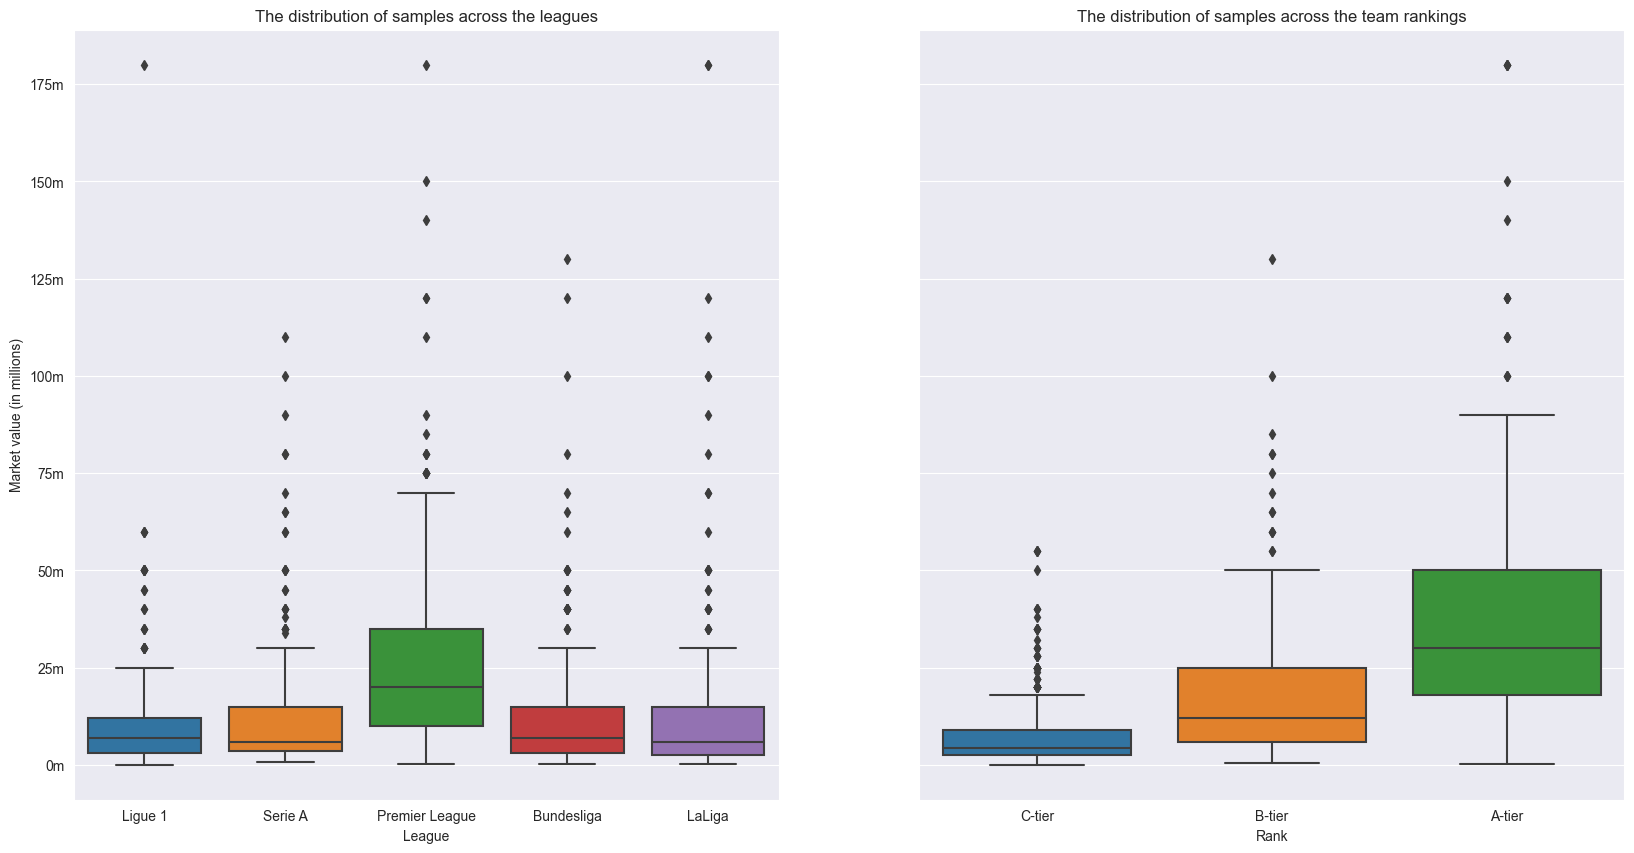

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.boxplot(all_data,
            x='League',
            y='Value',
            ax=ax[0])

sns.boxplot(all_data,
            x='Team_rank',
            y='Value',
            order=reversed(order_rank),
            ax=ax[1])

ax[0].set_title('The distribution of samples across the leagues')
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_title('The distribution of samples across the team rankings')
ax[1].set_xlabel('Rank')
ax[1].set_ylabel('')

plt.show()

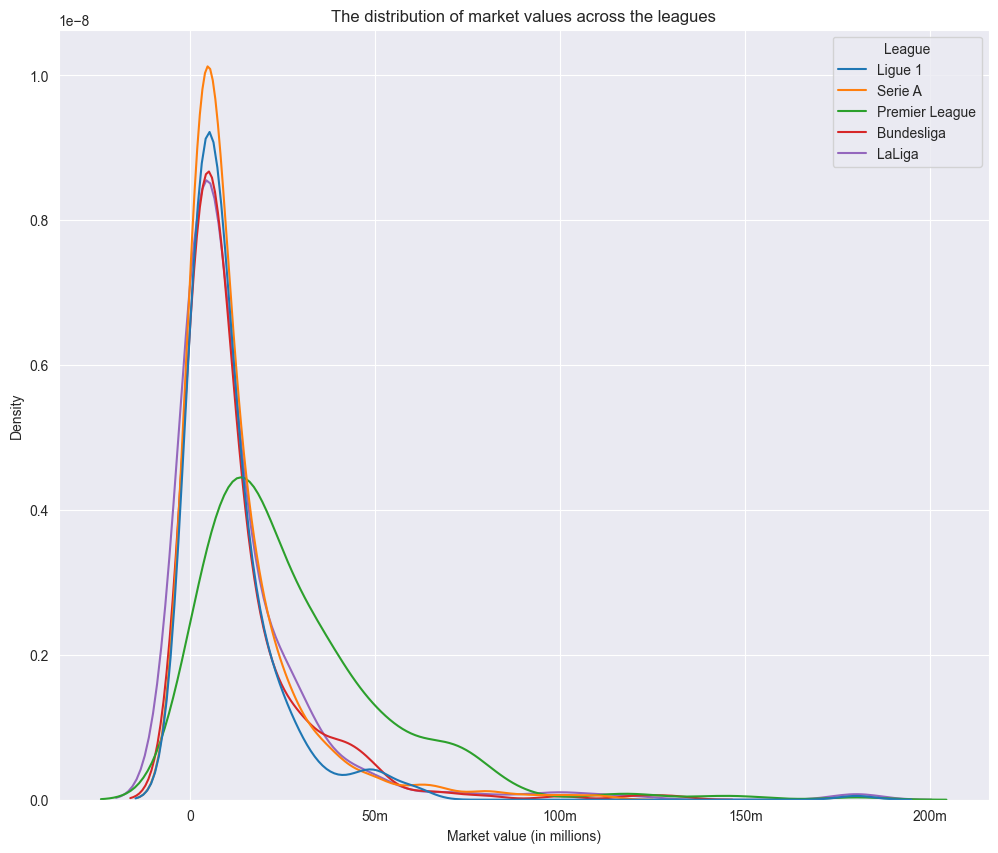

In [33]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='League')

ax.set_title('The distribution of market values across the leagues')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

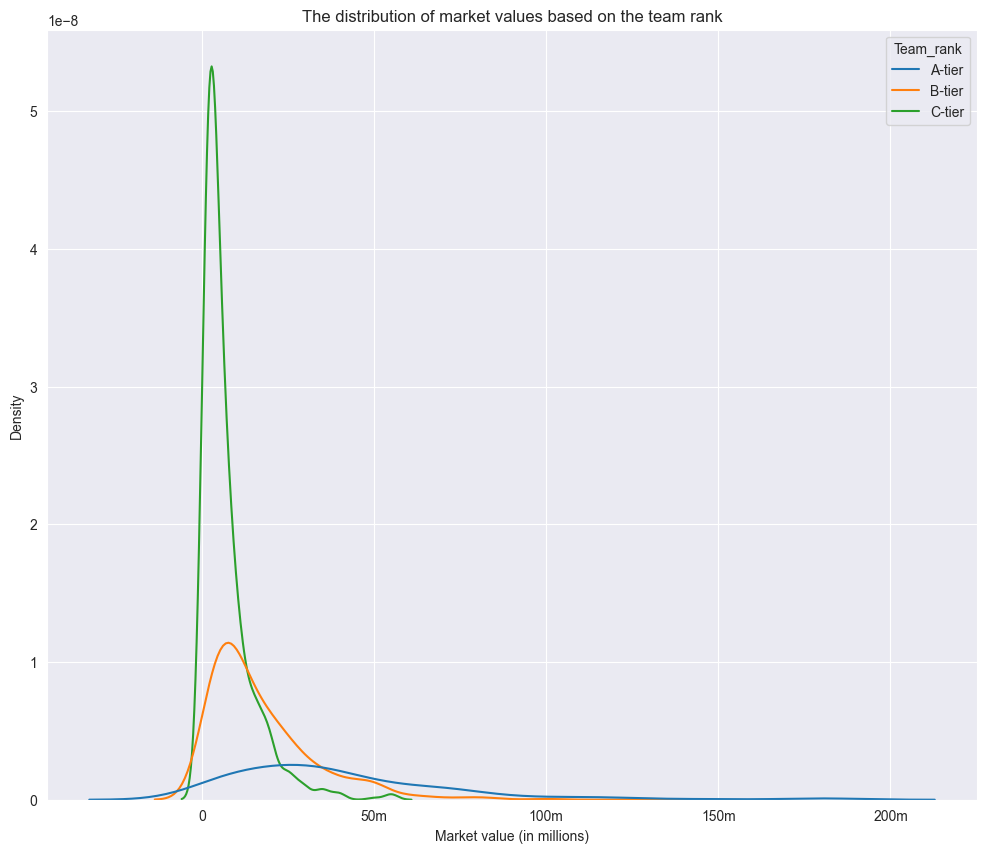

In [34]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='Team_rank',
            hue_order=order_rank)

ax.set_title('The distribution of market values based on the team rank')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

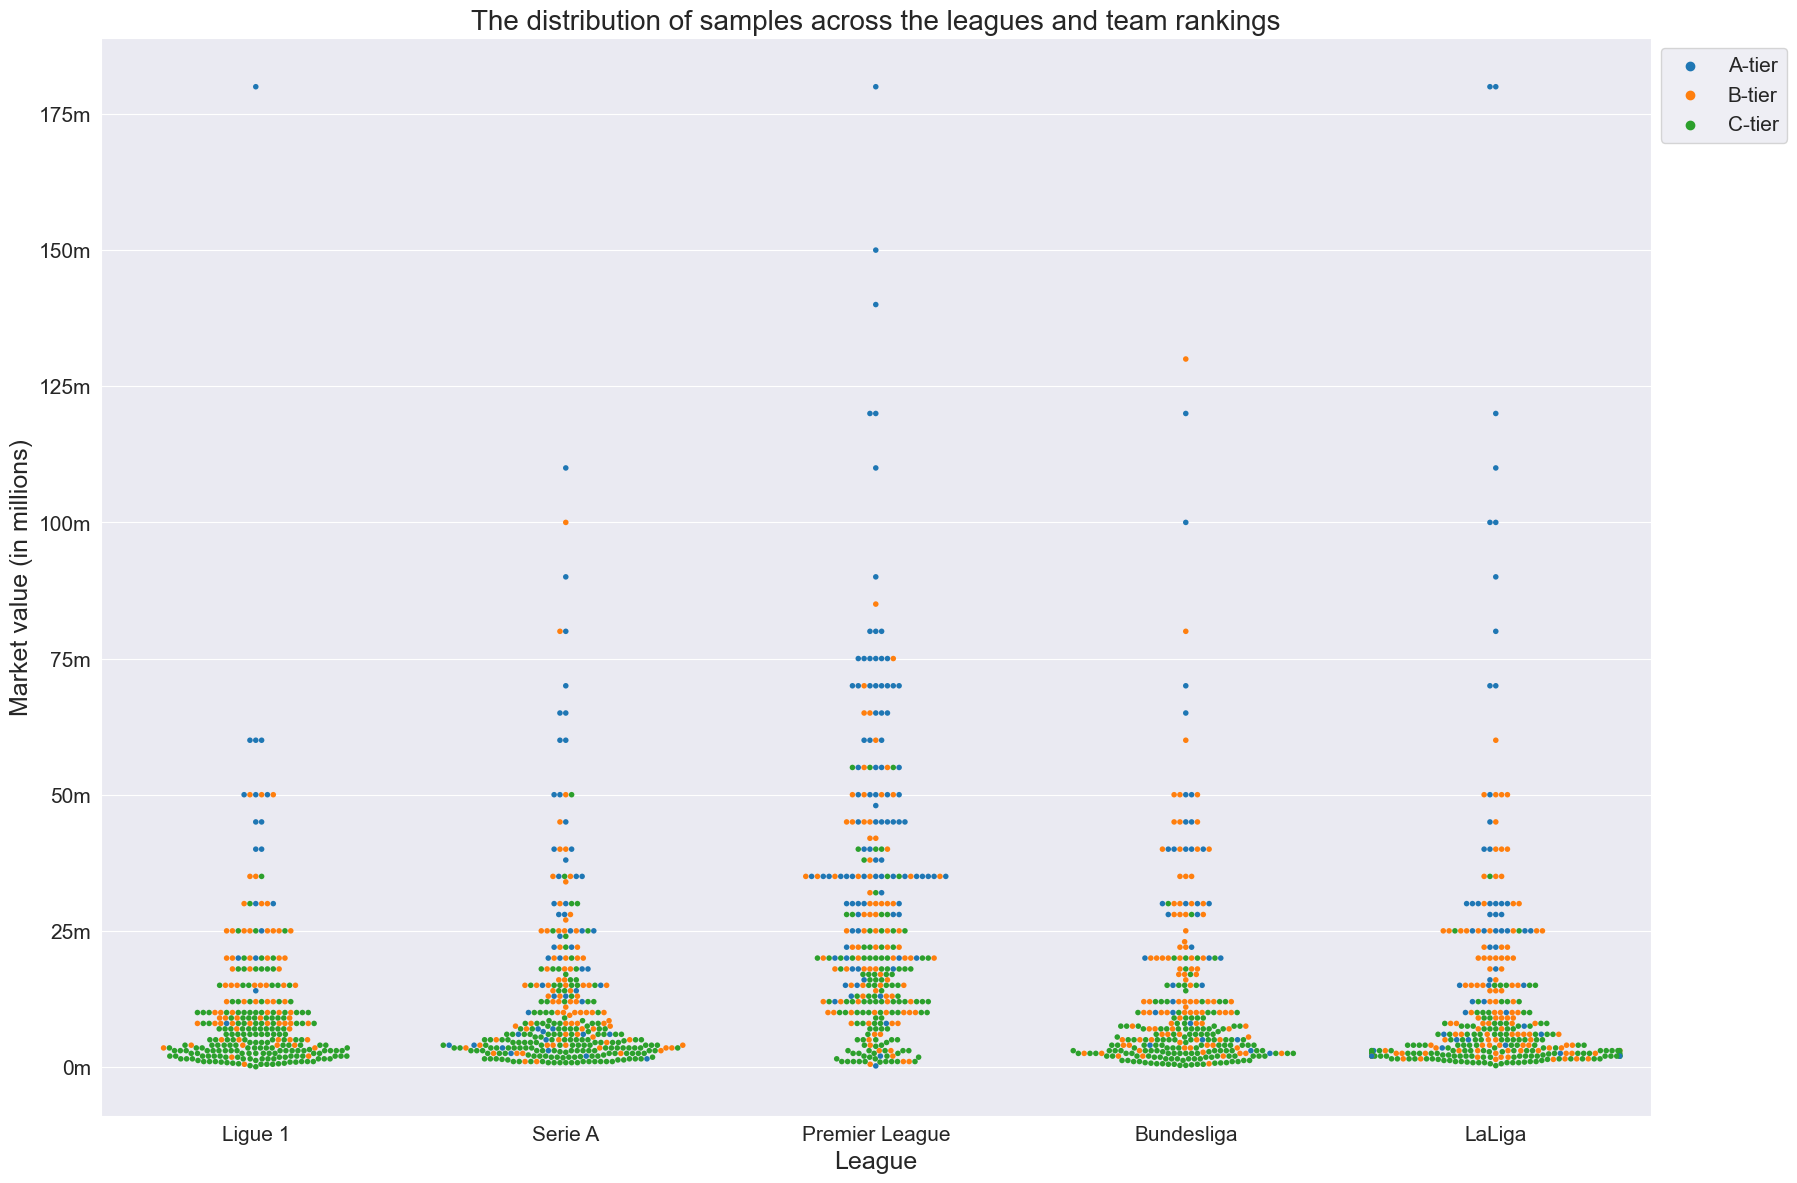

In [35]:
fig, ax = plt.subplots(figsize=(20, 14))

sns.swarmplot(all_data,
              x='League',
              y='Value',
              size=4,
              hue='Team_rank',
              hue_order=order_rank,
              ax=ax)

ax.set_title('The distribution of samples across the leagues and team rankings', fontsize=20)
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)', fontsize=18)
ax.xaxis.label.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=15)

plt.show()

On the first graph we can see that the distributions are almost the same across the leagues, but the Premier league has a little bit different one with higher market values than for other leagues.

From the second one we can notice that the distributions for A-ranked and B-ranked clubs are more heavy-tailed than for C-ranked teams, and in general, the majority of players in "small clubs" are located on the left part of the graph.

In [36]:
# Creates a table with different descriptive statistics for different groups of a categorical variable 
def descriptive_table(table, variable):
    indices=table.groupby(variable)['Value'].mean().index
    counts = table.groupby(variable)['Value'].count().values
    means = table.groupby(variable)['Value'].mean().values
    stds = table.groupby(variable)['Value'].std().values
    medians = table.groupby(variable)['Value'].median().values
    quantile_ninty = table.groupby(variable)['Value'].quantile(q=0.9).values
    
    table =  pd.DataFrame({'Sample size': counts,
                           'Mean': means,
                           'St. deviation': stds,
                           'Median': medians,
                           '90% quantile': quantile_ninty
                           }, index=indices)
    return table    

In [37]:
for item in ['League', 'Team_rank']:
    print(f"Variable: {item}")
    display(descriptive_table(all_data, item))

Variable: League


Sample size          Mean  St. deviation      Median  \
League                                                                 
Bundesliga              296  1.282111e+07   1.714876e+07   7000000.0   
LaLiga                  329  1.309073e+07   2.152709e+07   6000000.0   
Ligue 1                 284  1.107042e+07   1.529310e+07   7000000.0   
Premier League          314  2.796656e+07   2.559655e+07  20000000.0   
Serie A                 323  1.243467e+07   1.585947e+07   6000000.0   

                90% quantile  
League                        
Bundesliga        30000000.0  
LaLiga            30000000.0  
Ligue 1           25000000.0  
Premier League    63500000.0  
Serie A           29600000.0

Variable: Team_rank


Sample size          Mean  St. deviation      Median  90% quantile
Team_rank                                                                    
A-tier             252  3.962778e+07   3.309946e+07  30000000.0    75000000.0
B-tier             474  1.748692e+07   1.617146e+07  12000000.0    40000000.0
C-tier             820  7.035122e+06   7.529375e+06   4250000.0    17000000.0

**Idea**: We can create a variable that indicates whether some footballer plays in Premier League instead of 'League' column

In [38]:
all_data['From EPL'] = all_data['League'] == 'Premier League'

In [39]:
all_data['Champion'] = all_data['Team'].isin(['Inter', 'Real Madrid', 'Leverkusen', 'Man City', 'PSG'])

Now we will work with positions. It can be very useful to divide player`s positions into four groups (attack, midfield, defence and goalkeeper) because we can expect that the players in attack line cost more than goalkeepers. We will only operate with the main position and create 'Position' column.

In [40]:
position_mapping = {'FW': 'Attack',
                    'AM': 'Midfield',
                    'M': 'Midfield',
                    'DMC': 'Midfield',
                    'D': 'Defence',
                    'GK': 'Goalkeeper'}

all_data['Position'] = all_data['Position_1'].map(position_mapping)

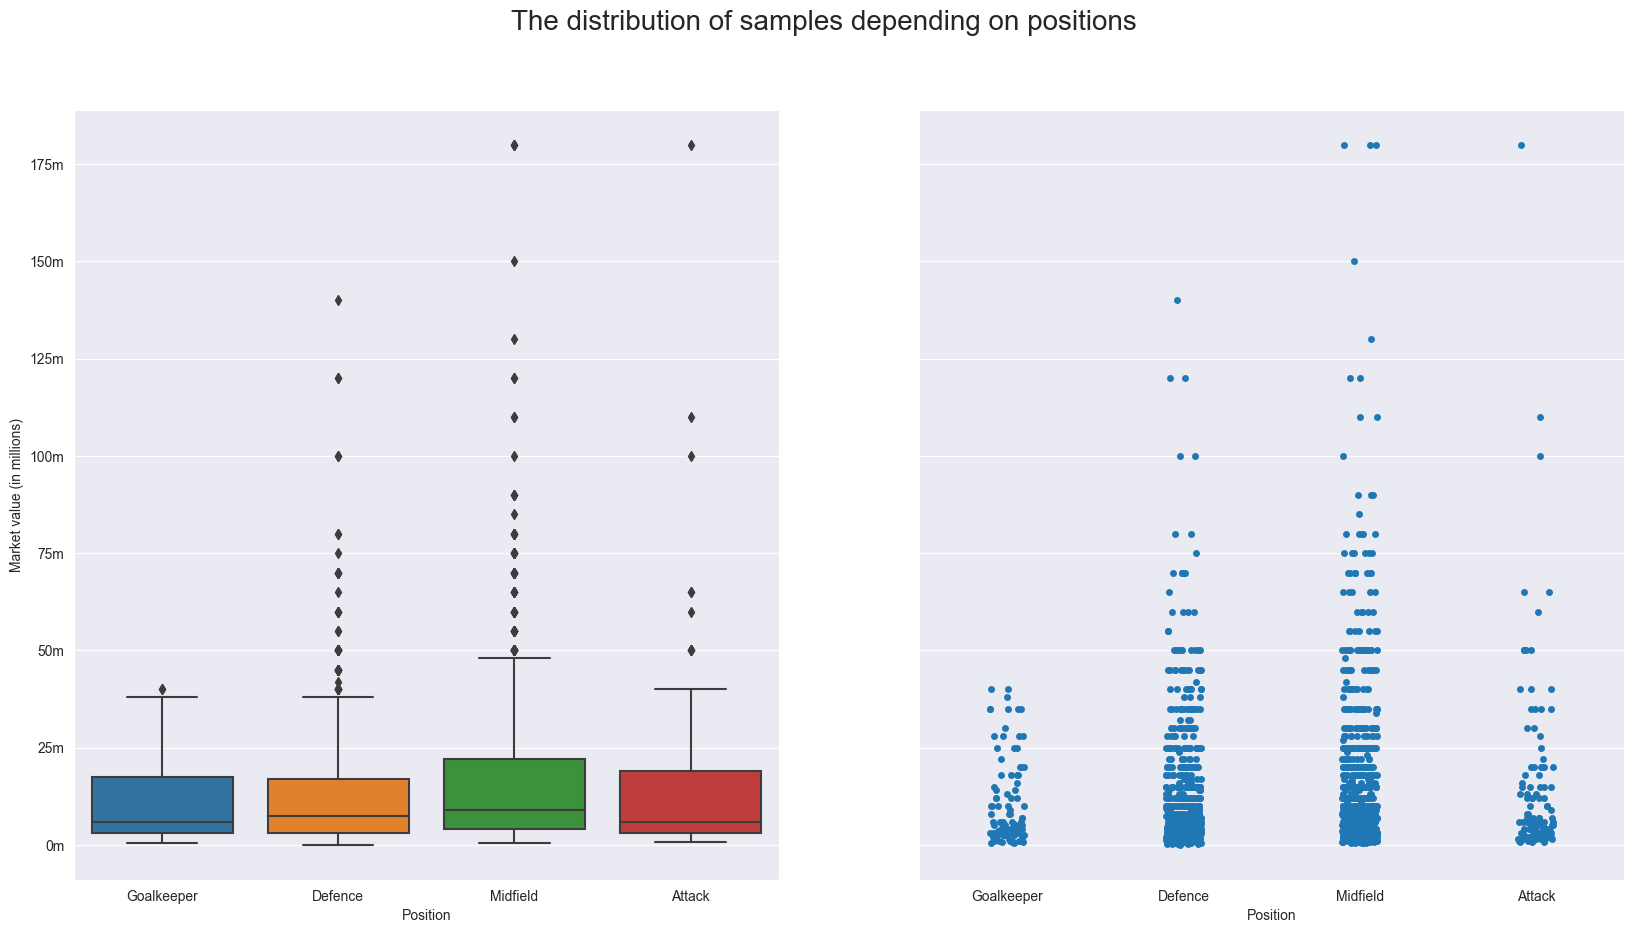

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

position_rank = ['Goalkeeper', 'Defence', 'Midfield', 'Attack']

sns.boxplot(all_data,
            x='Position',
            y='Value',
            order=position_rank,
            ax=ax[0])

sns.stripplot(all_data,
              x='Position',
              y='Value',
              order=position_rank,
              ax=ax[1])

fig.suptitle('The distribution of samples depending on positions', fontsize=20)
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_ylabel('')

plt.show()

In [42]:
display(descriptive_table(all_data, 'Position'))

Sample size          Mean  St. deviation     Median  90% quantile
Position                                                                     
Attack              111  1.616396e+07   2.488179e+07  6000000.0    40000000.0
Defence             618  1.359684e+07   1.715473e+07  7500000.0    35000000.0
Goalkeeper           94  1.108936e+07   1.100055e+07  6000000.0    28000000.0
Midfield            723  1.771003e+07   2.305809e+07  9000000.0    45000000.0

In [43]:
# Significance test for some categorical variable
def significance_test(variable, transformation=False, test_type=None):
    groups = []

    for group in all_data[variable].unique():
        sample = all_data.query(variable + '== @group')['Value'].values
        
        if transformation == 'log': 
            sample = np.log(sample + 1)
        elif transformation == 'sqrt': 
            sample = np.sqrt(np.abs(sample))
            
        print(f'Shapiro-Wilk test: {shapiro(sample)}')
        groups.append(sample)

    print(f'Levene: {levene(*groups)}')
    
    if test_type == 'anova':
        print(f'ANOVA test: {f_oneway(*groups)}')
    elif test_type == 'kruskal':
        for g in groups:
            np.sort(g)
            
        print(f'Kruskal-Wallis test: {kruskal(*groups)}')

In [44]:
significance_test('Position')

Shapiro-Wilk test: ShapiroResult(statistic=0.6761902859086902, pvalue=6.197708076654985e-35)
Shapiro-Wilk test: ShapiroResult(statistic=0.820127441024127, pvalue=2.441868285597932e-09)
Shapiro-Wilk test: ShapiroResult(statistic=0.5910474408709383, pvalue=4.2454838122298744e-16)
Shapiro-Wilk test: ShapiroResult(statistic=0.6923282909868966, pvalue=4.8918881744521404e-32)
Levene: LeveneResult(statistic=5.071962668203488, pvalue=0.001695870592367609)


The samples aren`t distributed normally and their variances differ significantly, but we can use transformations

In [45]:
for tr in ['log', 'sqrt']:
    significance_test('Position', transformation=tr)
    print()
    print('=' * 25)
    print()

Shapiro-Wilk test: ShapiroResult(statistic=0.9911483603510157, pvalue=0.00025009395067626433)
Shapiro-Wilk test: ShapiroResult(statistic=0.9638427394140349, pvalue=0.010609204782735901)
Shapiro-Wilk test: ShapiroResult(statistic=0.9810127009464324, pvalue=0.11544302038132292)
Shapiro-Wilk test: ShapiroResult(statistic=0.9908761008326488, pvalue=0.0007225419010297908)
Levene: LeveneResult(statistic=0.23173730875181117, pvalue=0.8743134437741662)


Shapiro-Wilk test: ShapiroResult(statistic=0.8978465520242858, pvalue=1.5981228275437358e-21)
Shapiro-Wilk test: ShapiroResult(statistic=0.9240363383959092, pvalue=3.984101043060345e-05)
Shapiro-Wilk test: ShapiroResult(statistic=0.8419662299523764, pvalue=1.5549967643470708e-09)
Shapiro-Wilk test: ShapiroResult(statistic=0.9034120742644598, pvalue=2.527130728362949e-19)
Levene: LeveneResult(statistic=3.6987904334092474, pvalue=0.01140466767212007)




The samples` distribution is still abnormal, but their variances are homogenous, so we can try to use Kruskal-Wallis test (we cannot use ANOVA test)

In [46]:
print('Without transformation: ')
significance_test('Position', transformation=False, test_type='kruskal')

Without transformation: 
Shapiro-Wilk test: ShapiroResult(statistic=0.6761902859086902, pvalue=6.197708076654985e-35)
Shapiro-Wilk test: ShapiroResult(statistic=0.820127441024127, pvalue=2.441868285597932e-09)
Shapiro-Wilk test: ShapiroResult(statistic=0.5910474408709383, pvalue=4.2454838122298744e-16)
Shapiro-Wilk test: ShapiroResult(statistic=0.6923282909868966, pvalue=4.8918881744521404e-32)
Levene: LeveneResult(statistic=5.071962668203488, pvalue=0.001695870592367609)
Kruskal-Wallis test: KruskalResult(statistic=15.038079641393859, pvalue=0.0017843947425119037)


In [47]:
print('With log transformation: ')
significance_test('Position', transformation='log', test_type='kruskal')

With log transformation: 
Shapiro-Wilk test: ShapiroResult(statistic=0.9911483603510157, pvalue=0.00025009395067626433)
Shapiro-Wilk test: ShapiroResult(statistic=0.9638427394140349, pvalue=0.010609204782735901)
Shapiro-Wilk test: ShapiroResult(statistic=0.9810127009464324, pvalue=0.11544302038132292)
Shapiro-Wilk test: ShapiroResult(statistic=0.9908761008326488, pvalue=0.0007225419010297908)
Levene: LeveneResult(statistic=0.23173730875181117, pvalue=0.8743134437741662)
Kruskal-Wallis test: KruskalResult(statistic=15.038079641393859, pvalue=0.0017843947425119037)


Since Kruskal-Wallis test shows significant result, we can leave this variable

Let`s check 'Side_11' variable because it is footballer's main side (location where he usually plays)

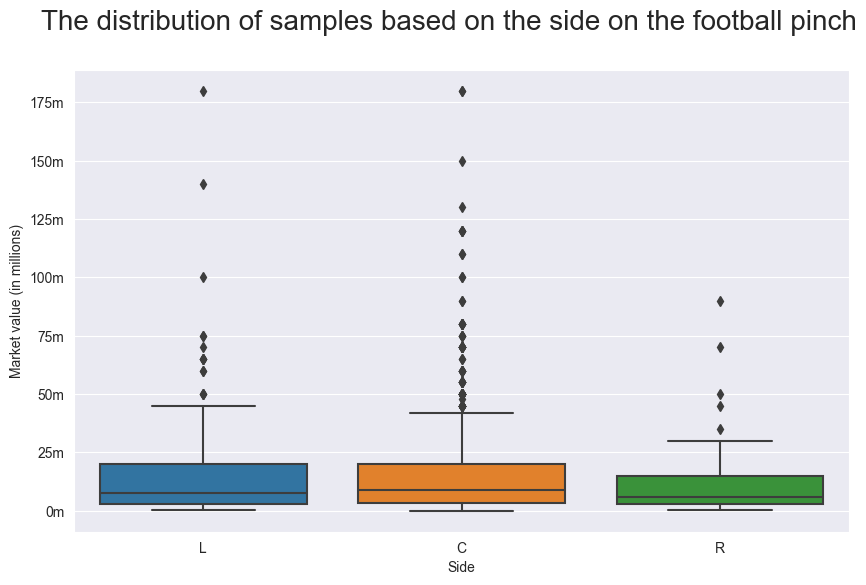

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

side_rank = ['L', 'C', 'R']

sns.boxplot(all_data,
            x='Side_11',
            y='Value',
            order=side_rank,
            ax=ax)

fig.suptitle('The distribution of samples based on the side on the football pinch', fontsize=20)
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')
ax.set_xlabel('Side')

plt.show()

In [49]:
descriptive_table(all_data, 'Side_11')

Sample size          Mean  St. deviation     Median  90% quantile
Side_11                                                                   
C                881  1.690159e+07   2.164405e+07  9000000.0    42000000.0
L                237  1.511181e+07   2.128865e+07  7500000.0    35000000.0
R                115  1.097565e+07   1.338361e+07  6000000.0    25000000.0

In [50]:
all_data['Side_11'].fillna(all_data['Side_11'].mode().values[0], inplace=True)
#all_data['Side_11'] = all_data.groupby('Position')['Side_11'].transform(lambda x: x.fillna(x.mode()))

In [51]:
all_data.rename(columns={'Side_11': 'Main side'}, inplace=True)

This variable is not so useful as the previous ones. There are too little data for Left and Right sides, and we can expect that 'Side_12', 'Side_13', etc. are even less informative, so in the future we can drop them, leaving only 'Main_side' (it is the same as 'Side_11') variable.

Now we will work with 'Position_1_Sides' and 'Position_2_Sides' and create some interesting (at least we hope) plots

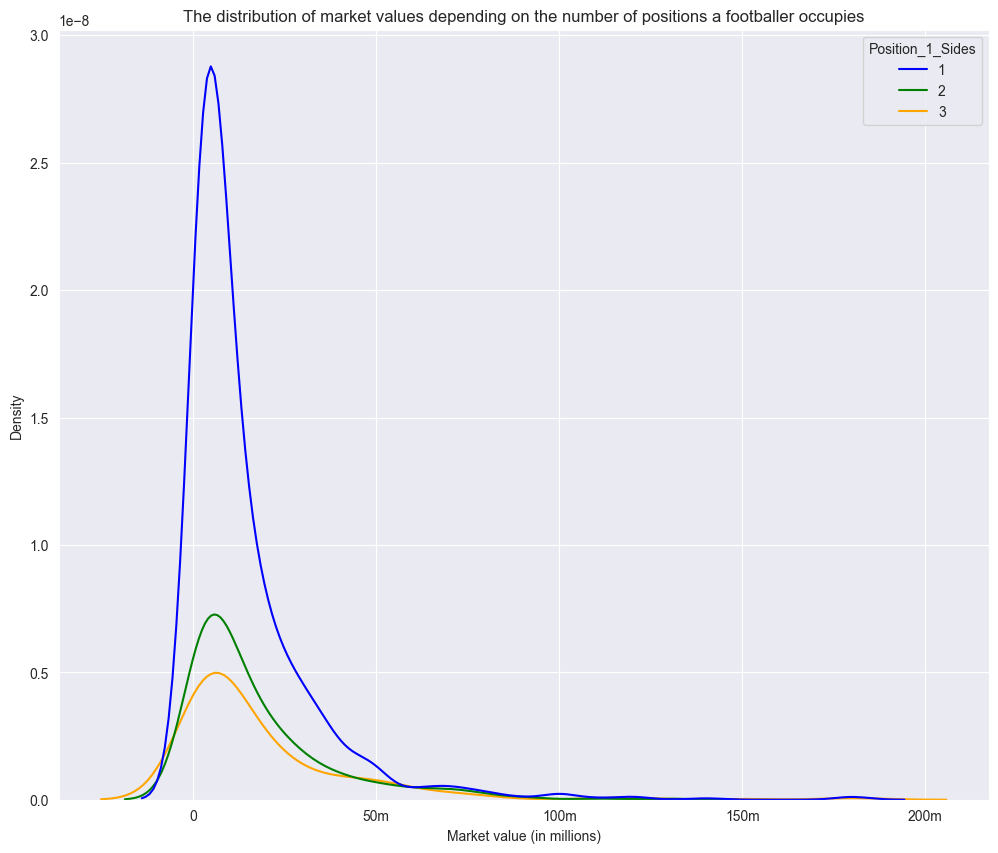

In [52]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='Position_1_Sides',
            palette=['blue', 'green', 'orange'])

ax.set_title('The distribution of market values depending on the number of positions a footballer occupies')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

Now let`s work with numerical variables  

In [53]:
all_data.describe()

Age         Mins        Goals      Assists         Yel  \
count  1546.000000  1546.000000  1546.000000  1546.000000  1546.00000   
mean     26.873868  1918.762613     2.850582     2.004528     3.93467   
std       4.115202   706.446517     3.931821     2.298863     2.68333   
min      16.000000   195.000000     0.000000     0.000000     0.00000   
25%      24.000000  1376.250000     0.000000     0.000000     2.00000   
50%      27.000000  1913.000000     1.000000     1.000000     4.00000   
75%      30.000000  2485.000000     4.000000     3.000000     5.00000   
max      40.000000  3420.000000    36.000000    14.000000    17.00000   

               Red          SpG           PS   AerialsWon         MotM  ...  \
count  1546.000000  1546.000000  1546.000000  1546.000000  1546.000000  ...   
mean      0.174644     0.894825    80.035511     0.962678     1.038163  ...   
std       0.415591     0.692623     7.927905     0.852841     1.464300  ...   
min       0.000000     0.000000    44.900000     0.000000     0.000000  ...   
25%       0.000000     0.400000    75.700000     0.400000     0.000000  ...   
50%       0.000000     0.700000    81.100000     0.700000     1.000000  ...   
75%       0.000000     1.275000    85.600000     1.300000     2.000000  ...   
max       3.000000     4.600000    95.400000     6.800000    10.000000  ...   

           Crosses        LongB         ThrB  Clean Sheets %   Popularity  \
count  1546.000000  1546.000000  1546.000000     1546.000000  1546.000000   
mean      0.301035     1.638616     0.040621        0.015691     1.257576   
std       0.413790     1.662868     0.070546        0.068564     0.702769   
min       0.000000     0.000000     0.000000        0.000000     0.212000   
25%       0.000000     0.500000     0.000000        0.000000     1.000000   
50%       0.100000     1.100000     0.000000        0.000000     1.000000   
75%       0.400000     2.200000     0.100000        0.000000     1.000000   
max       2.900000    15.400000     0.600000        0.559000     5.000000   

       Overall_Apps   Start_Apps         Value  Position_1_Sides  \
count   1546.000000  1546.000000  1.546000e+03       1546.000000   
mean      17.393920     7.135834  1.555226e+07          1.563389   
std        9.582248     5.527306  2.054976e+07          0.770948   
min        0.000000     1.000000  5.000000e+04          1.000000   
25%       10.000000     3.000000  3.000000e+06          1.000000   
50%       18.000000     5.000000  8.000000e+06          1.000000   
75%       25.000000    11.000000  2.000000e+07          2.000000   
max       37.000000    28.000000  1.800000e+08          3.000000   

       Position_2_Sides  
count       1546.000000  
mean           1.077620  
std            0.328462  
min            1.000000  
25%            1.000000  
50%            1.000000  
75%            1.000000  
max            3.000000  

[8 rows x 36 columns]

In [54]:
df_train, df_test = divide_df(all_data)

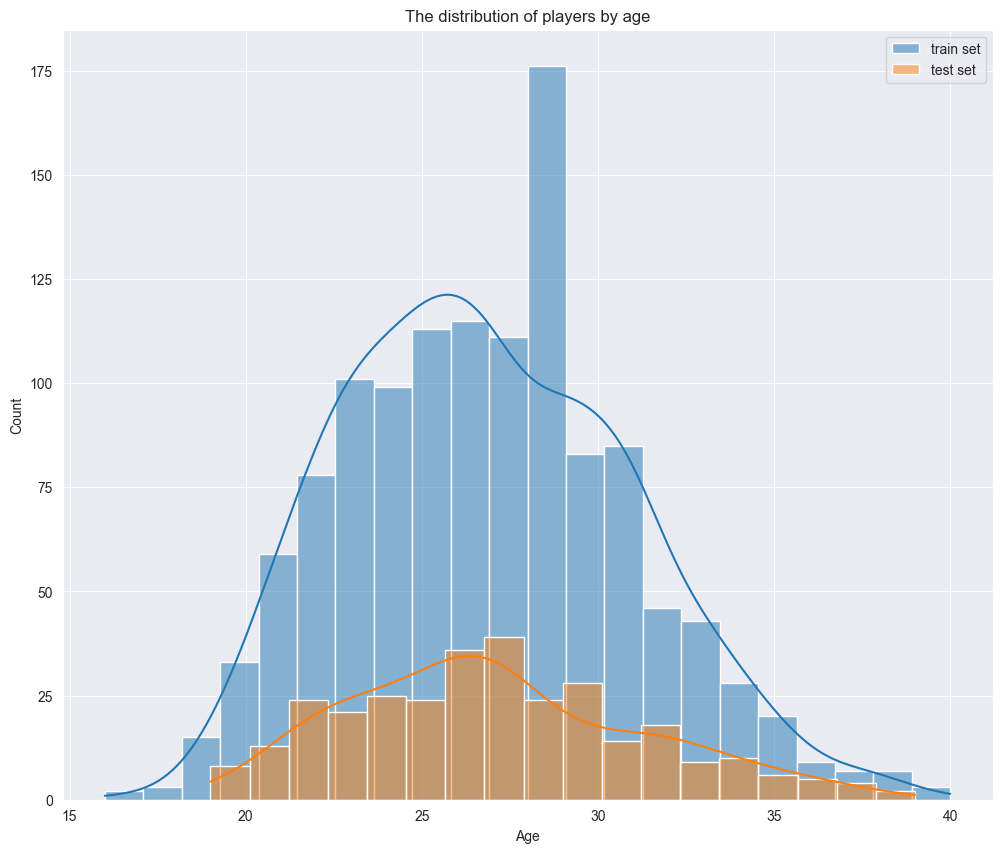

In [55]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.histplot(df_train,
            x='Age',
            kde=True,
            ax=ax,
            label='train set')

sns.histplot(df_test,
            x='Age',
            kde=True,
            bins=18,
            ax=ax,
            label='test set')

ax.set_title('The distribution of players by age')
ax.set_xlabel('Age')
ax.legend()

plt.show()

In [56]:
#all_data['Age'] = pd.cut(all_data['Age'], bins=4)

In [57]:
all_data['Very old'] = all_data['Age'] >= 32

In [58]:
df_train, df_test = divide_df(all_data)

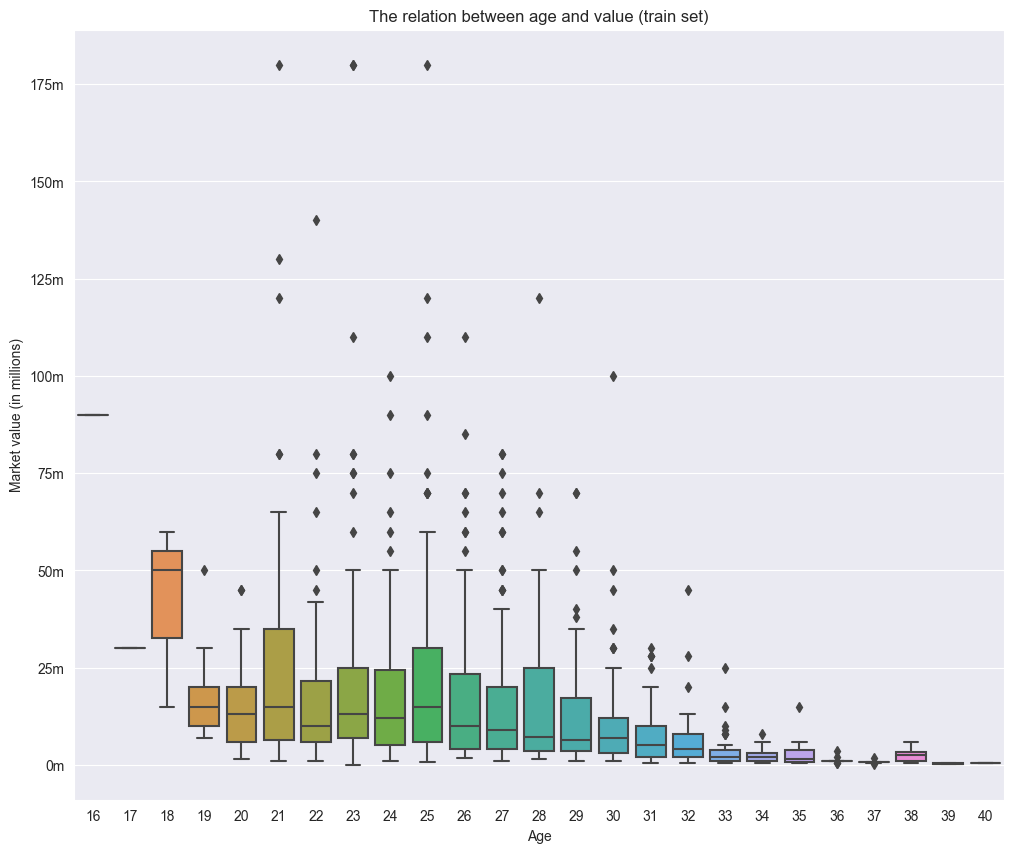

In [59]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(df_train,
            x='Age',
            y='Value',
            ax=ax)

ax.set_title('The relation between age and value (train set)')
ax.set_xlabel('Age')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

In [60]:
descriptive_table(df_train, 'Age')

Sample size          Mean  St. deviation      Median  90% quantile
Age                                                                    
16             1  9.000000e+07            NaN  90000000.0    90000000.0
17             1  3.000000e+07            NaN  30000000.0    30000000.0
18             3  4.166667e+07   2.362908e+07  50000000.0    58000000.0
19            15  1.773333e+07   1.132927e+07  15000000.0    29200000.0
20            33  1.562121e+07   1.177791e+07  13000000.0    30000000.0
21            59  2.679661e+07   3.376122e+07  15000000.0    61000000.0
22            78  1.758462e+07   2.118411e+07  10000000.0    35000000.0
23           101  2.330545e+07   3.044781e+07  13000000.0    50000000.0
24            99  1.828384e+07   1.885654e+07  12000000.0    40000000.0
25           113  2.375221e+07   2.718071e+07  15000000.0    50000000.0
26           115  1.800000e+07   1.967590e+07  10000000.0    41200000.0
27           111  1.641712e+07   1.849116e+07   9000000.0    45000000.0
28            80  1.622250e+07   1.982668e+07   7250000.0    40000000.0
29            96  1.273542e+07   1.430854e+07   6500000.0    30000000.0
30            83  1.081928e+07   1.400044e+07   7000000.0    24400000.0
31            85  7.155882e+06   6.949809e+06   5000000.0    15600000.0
32            46  6.647826e+06   7.816840e+06   4000000.0    12000000.0
33            43  3.627907e+06   4.530181e+06   2000000.0     8000000.0
34            28  2.375000e+06   1.731329e+06   2000000.0     4000000.0
35            20  2.885000e+06   3.358458e+06   1500000.0     5100000.0
36             9  1.288889e+06   9.293068e+05   1000000.0     2300000.0
37             7  8.214286e+05   4.742161e+05    800000.0     1200000.0
38             7  2.471429e+06   1.984703e+06   2500000.0     4800000.0
39             2  3.500000e+05   2.121320e+05    350000.0      470000.0
40             1  5.000000e+05            NaN    500000.0      500000.0

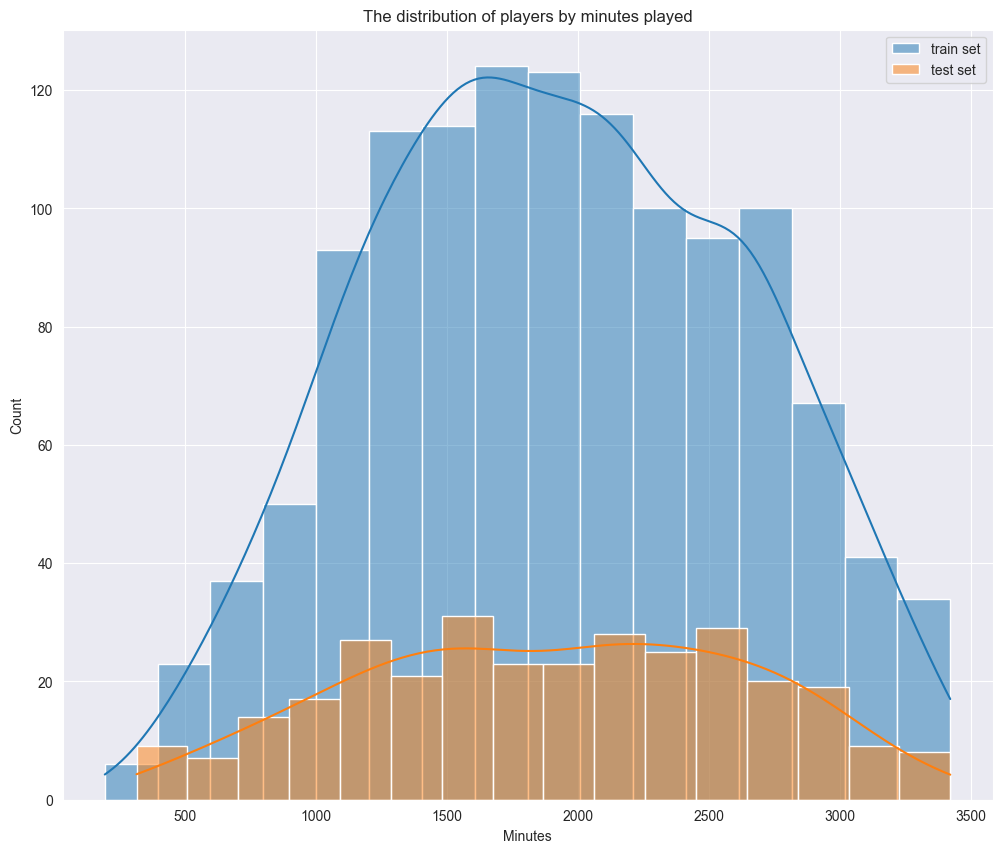

In [61]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.histplot(df_train,
            x='Mins',
            kde=True,
            ax=ax,
            label='train set')

sns.histplot(df_test,
            x='Mins',
            kde=True,
            bins=16,
            ax=ax,
            label='test set')

ax.set_title('The distribution of players by minutes played')
ax.set_xlabel('Minutes')
ax.legend()

plt.show()

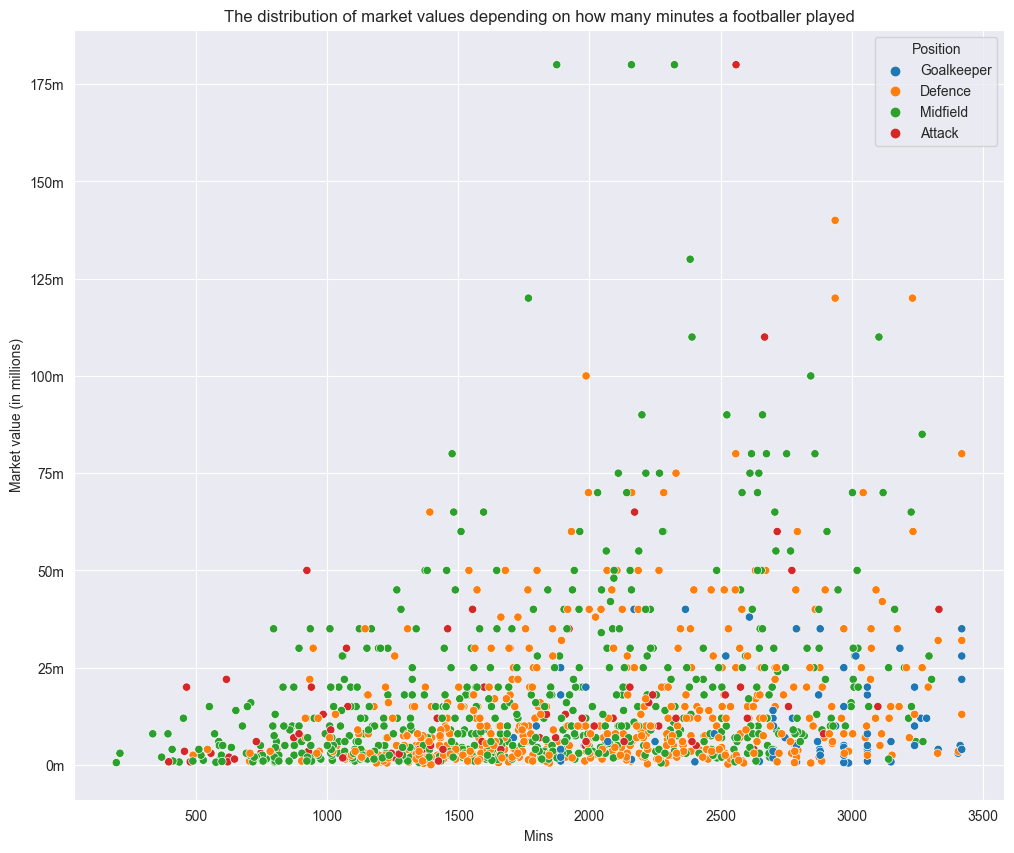

In [62]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.scatterplot(df_train,
            x='Mins',
            y='Value',
            hue='Position',
            hue_order=position_rank,
            ax=ax)

ax.set_title('The distribution of market values depending on how many minutes a footballer played')
ax.set_xlabel('Mins')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

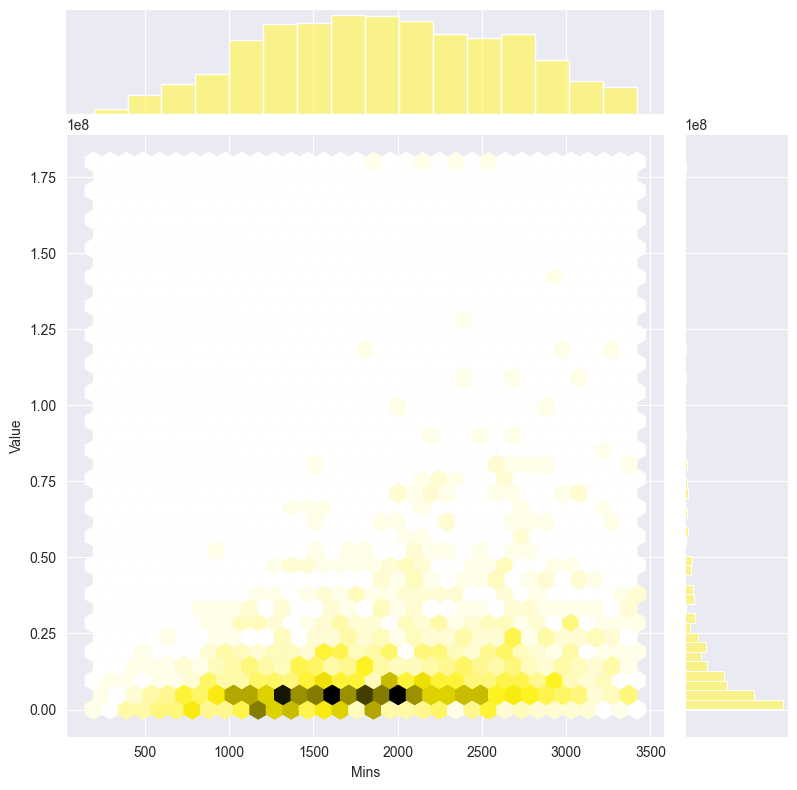

In [63]:
sns.jointplot(df_train,
              x='Mins',
              y='Value',
              kind="hex", 
              height=8,
              color="#FFF668")

plt.show()

In [64]:
#all_data['Minutes for MotM'] = all_data['Mins'] / all_data['MotM']
#all_data['Minutes for Goal'] = all_data['Mins'] / all_data['Goals']
#all_data['Minutes for Assist'] = all_data['Mins'] / all_data['Assists']
#all_data['Minutes for KeyP'] = all_data['Mins'] / all_data['KeyP']

In [65]:
#all_data['Mins'] = pd.qcut(all_data['Mins'], q=4)
df_train, df_test = divide_df(all_data)

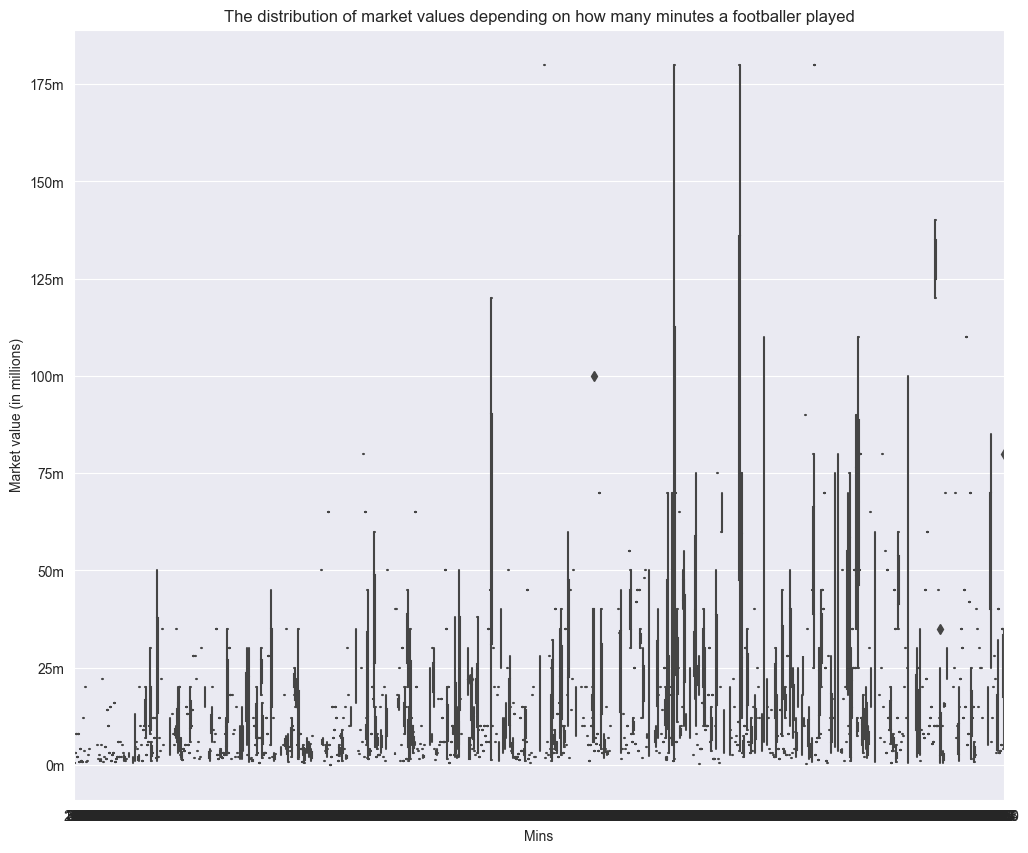

In [66]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(df_train,
            x='Mins',
            y='Value',
            ax=ax)

ax.set_title('The distribution of market values depending on how many minutes a footballer played')
ax.set_xlabel('Mins')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

In [67]:
descriptive_table(df_train, 'Mins')

Sample size          Mean  St. deviation      Median  90% quantile
Mins                                                                    
195             1  6.000000e+05            NaN    600000.0      600000.0
209             1  3.000000e+06            NaN   3000000.0     3000000.0
334             1  8.000000e+06            NaN   8000000.0     8000000.0
368             1  2.000000e+06            NaN   2000000.0     2000000.0
392             1  8.000000e+06            NaN   8000000.0     8000000.0
...           ...           ...            ...         ...           ...
3406            1  3.000000e+06            NaN   3000000.0     3000000.0
3407            1  3.500000e+06            NaN   3500000.0     3500000.0
3414            1  5.000000e+06            NaN   5000000.0     5000000.0
3418            1  3.500000e+07            NaN  35000000.0    35000000.0
3420            7  3.057143e+07   2.435746e+07  28000000.0    53000000.0

[955 rows x 5 columns]

In [68]:
all_data['Goals'] = pd.cut(all_data['Goals'], bins=4)
all_data['Assists'] = pd.cut(all_data['Assists'], bins=4)

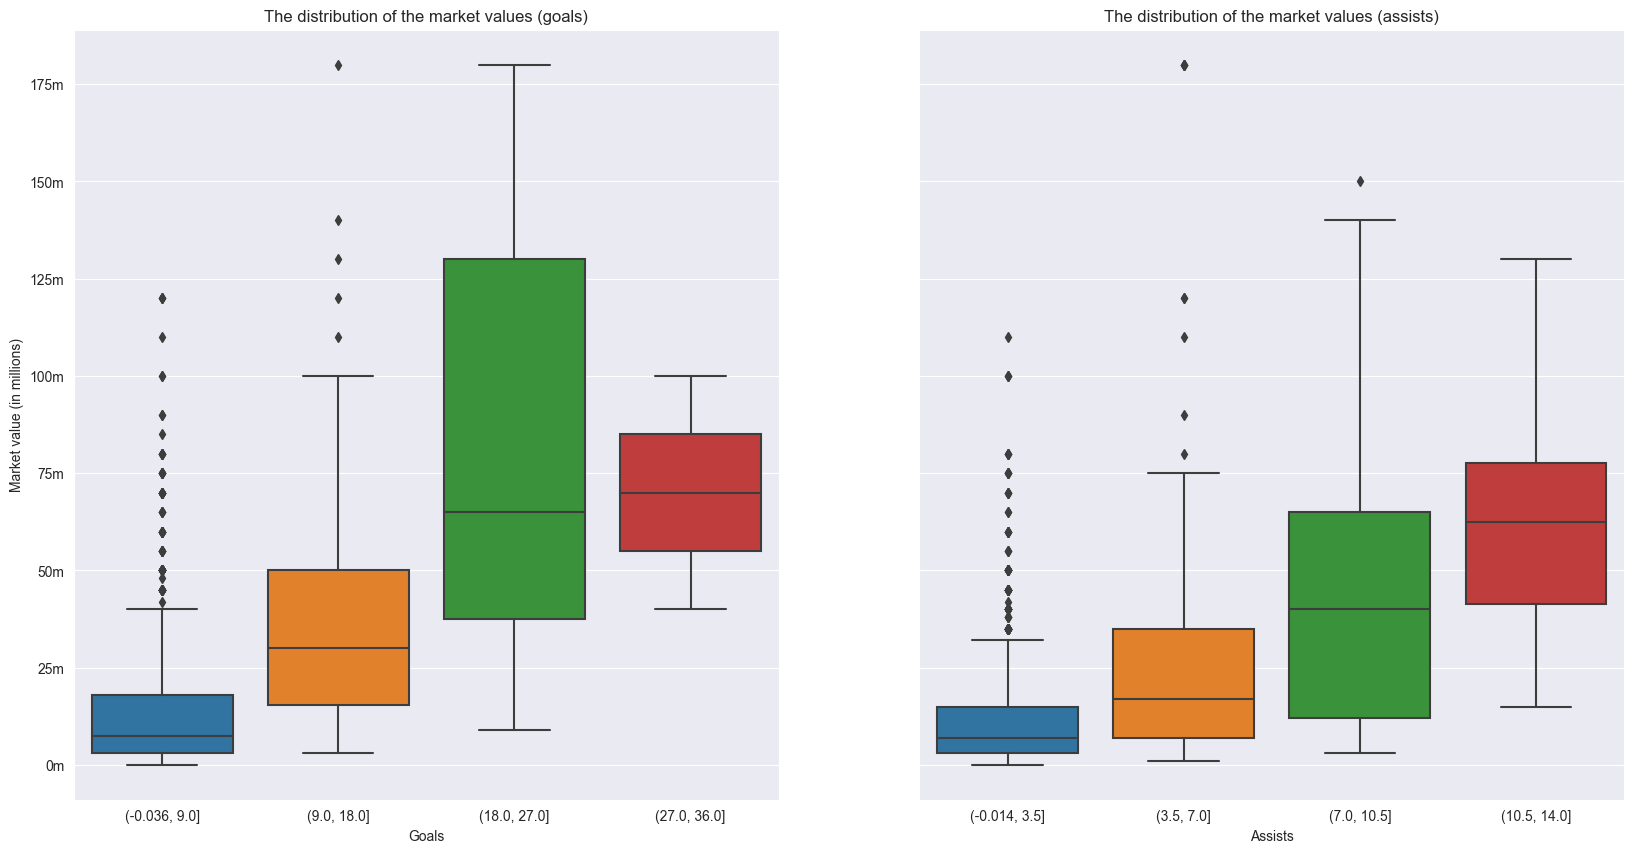

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.boxplot(all_data,
            x='Goals',
            y='Value',
            ax=ax[0])

sns.boxplot(all_data,
            x='Assists',
            y='Value',
            ax=ax[1])

ax[0].set_title('The distribution of the market values (goals)')
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_title('The distribution of the market values (assists)')
ax[1].set_ylabel('')

plt.show()

In [70]:
for item in ['Goals', 'Assists']:
    print(f'Variable: {item}')
    display(descriptive_table(all_data, item))

Variable: Goals


Sample size          Mean  St. deviation      Median  \
Goals                                                                 
(-0.036, 9.0]         1446  1.345768e+07   1.625314e+07   7500000.0   
(9.0, 18.0]             83  3.843373e+07   3.325188e+07  30000000.0   
(18.0, 27.0]            15  8.360000e+07   6.156970e+07  65000000.0   
(27.0, 36.0]             2  7.000000e+07   4.242641e+07  70000000.0   

               90% quantile  
Goals                        
(-0.036, 9.0]    35000000.0  
(9.0, 18.0]      70000000.0  
(18.0, 27.0]    180000000.0  
(27.0, 36.0]     94000000.0

Variable: Assists


Sample size          Mean  St. deviation      Median  \
Assists                                                               
(-0.014, 3.5]         1260  1.205135e+07   1.427802e+07   7000000.0   
(3.5, 7.0]             223  2.626502e+07   3.036211e+07  17000000.0   
(7.0, 10.5]             53  4.484906e+07   3.765961e+07  40000000.0   
(10.5, 14.0]            10  6.250000e+07   3.129164e+07  62500000.0   

               90% quantile  
Assists                      
(-0.014, 3.5]    30000000.0  
(3.5, 7.0]       55000000.0  
(7.0, 10.5]      98000000.0  
(10.5, 14.0]     85000000.0

Let`s drop redundant features or the features with missing values

In [71]:
all_data.drop(['Side_12', 'Side_13', 'Side_21', 'Side_22', 'League', 'Team',
               'Side_23', 'Position_1', 'Position_2', 'Position_2_Sides'], axis=1, inplace=True)

all_data, all_names = all_data.drop('Name', axis=1), all_data['Name']

train_names, test_names = divide_df(all_names) 

In [72]:
all_data.sample(10)

Age  Mins          Goals        Assists  Yel  Red  SpG    PS  \
1095   27  1488  (-0.036, 9.0]     (3.5, 7.0]    4    0  1.8  83.4   
696    25  2625  (-0.036, 9.0]   (10.5, 14.0]    4    0  1.6  67.2   
640    23  2564  (-0.036, 9.0]  (-0.014, 3.5]    3    0  1.9  81.2   
194    25  2573  (-0.036, 9.0]  (-0.014, 3.5]    4    0  0.3  79.0   
1279   25  2747  (-0.036, 9.0]     (3.5, 7.0]    5    0  0.5  92.3   
439    21  1515  (-0.036, 9.0]  (-0.014, 3.5]    2    0  0.5  80.7   
434    27  1810  (-0.036, 9.0]  (-0.014, 3.5]    1    0  0.7  74.3   
1269   33  2599  (-0.036, 9.0]     (3.5, 7.0]   10    0  0.5  85.1   
546    23  1472  (-0.036, 9.0]     (3.5, 7.0]    2    0  1.0  89.4   
1288   27  1971  (-0.036, 9.0]  (-0.014, 3.5]    3    0  0.4  93.0   

      AerialsWon  MotM  ...  Main side     Value  Position_1_Sides  Team_rank  \
1095         0.6     1  ...          L  45000000                 1     B-tier   
696          0.3     7  ...          L  15000000                 1     C-tier   
640          0.3     0  ...          C   7000000                 3     C-tier   
194          2.0     0  ...          C   7000000                 2     C-tier   
1279         0.2     0  ...          C  15000000                 2     B-tier   
439          0.3     0  ...          L   2000000                 1     C-tier   
434          0.5     1  ...          R   1800000                 1     C-tier   
1269         1.2     0  ...          C   7000000                 1     B-tier   
546          0.2     1  ...          C  25000000                 3     A-tier   
1288         3.0     1  ...          C  45000000                 1     A-tier   

      European tournament  Out of top5  From EPL  Champion  Position  Very old  
1095        Europa League        False      True     False  Midfield     False  
696                  None         True     False     False   Defence     False  
640                  None        False     False     False  Midfield     False  
194                  None        False      True     False   Defence     False  
1279                 None        False     False     False  Midfield     False  
439                  None        False     False     False  Midfield     False  
434                  None        False     False     False   Defence     False  
1269        Europa League        False     False     False   Defence      True  
546      Champions League        False     False      True  Midfield     False  
1288     Champions League        False     False     False   Defence     False  

[10 rows x 43 columns]

In [73]:
def pairplot_creator(table, index_start=0, index_end=40):
    new_table = table.iloc[:, index_start:index_end]
    new_table['Value'] = table['Value']
    
    sns.pairplot(new_table, height=2)
    plt.show()

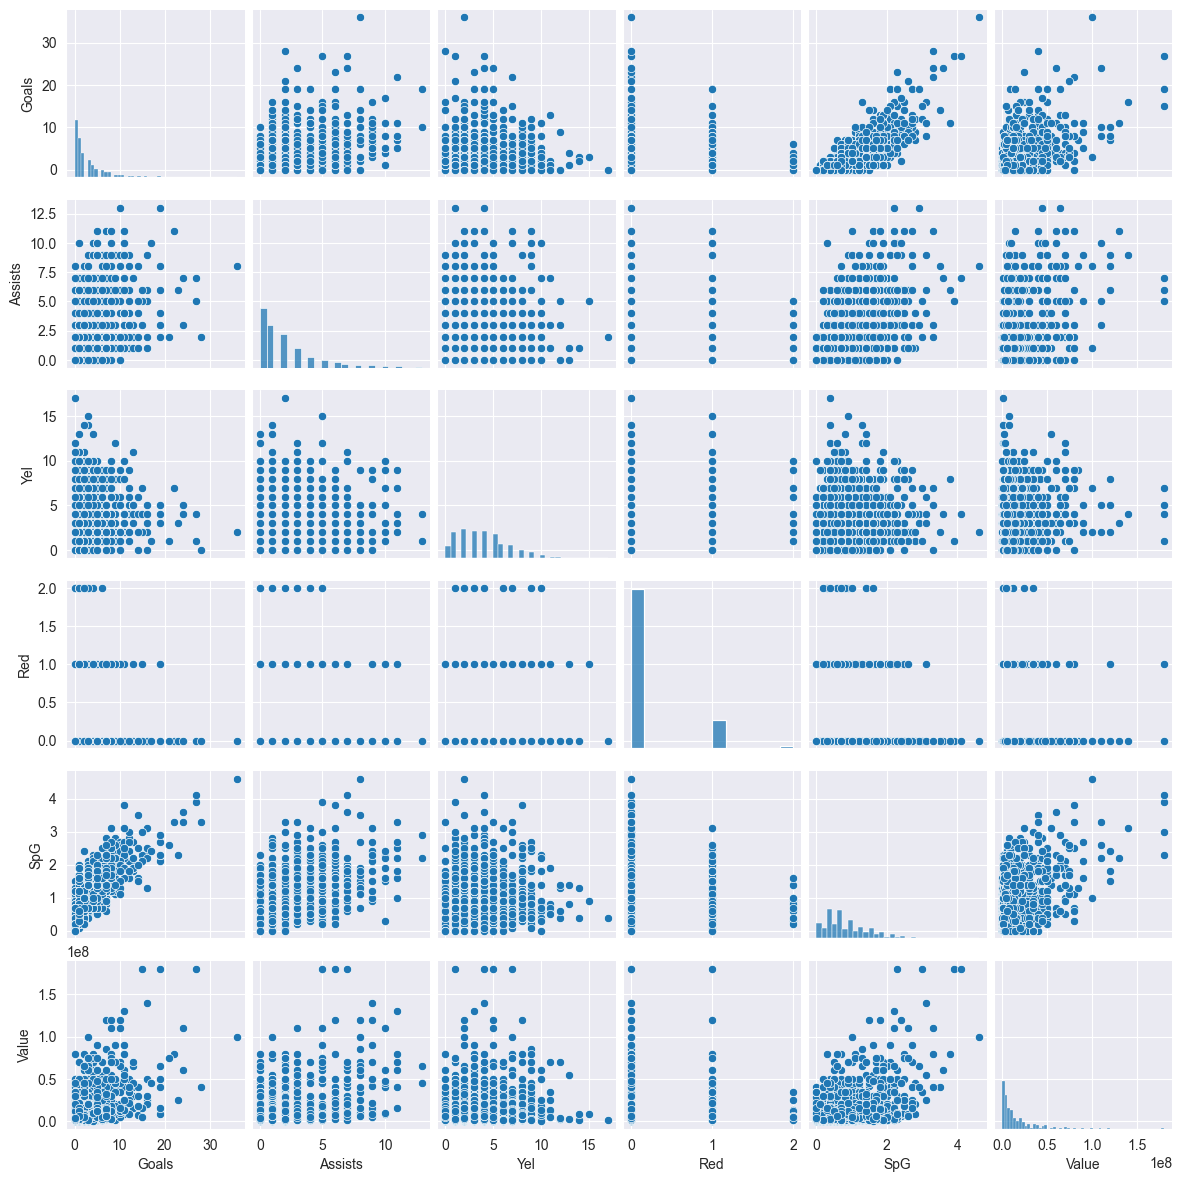

In [74]:
pairplot_creator(df_train, index_start=4, index_end=9)

In [75]:
# Insert 'Value' variable at the end of the dataset
value_column = all_data.pop('Value')
all_data['Value'] = value_column

In [76]:
df_train, df_test = divide_df(all_data)

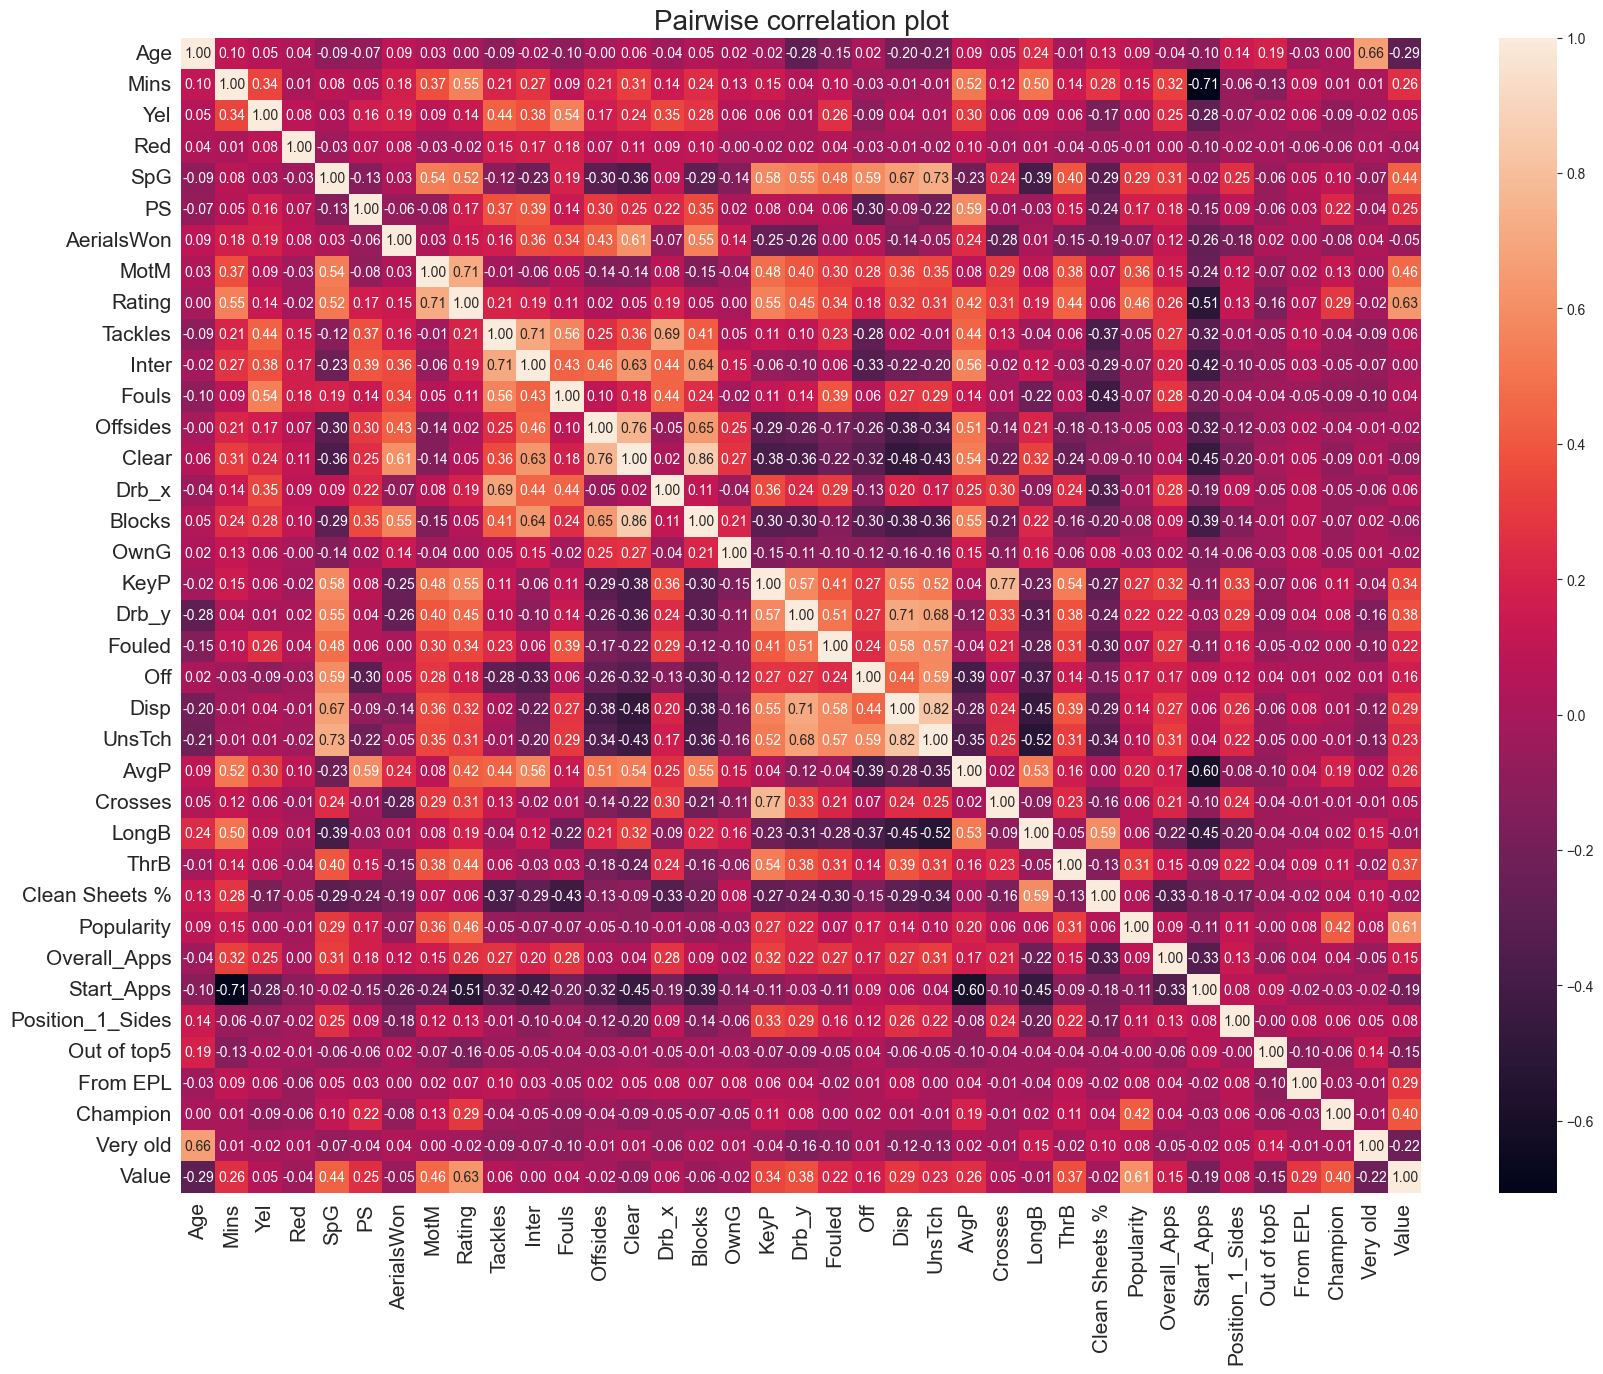

In [77]:
corr_table = df_train.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(corr_table,
            annot=True,
            fmt='.2f',
            ax=ax)

ax.set_title('Pairwise correlation plot', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

Let`s check the variance of some variables and use filter methods of feature selection

In [78]:
low_variance_correlation = []

for item in all_data.columns:
    if (all_data[item].dtype == 'int64' or all_data[item].dtype == 'float') and not item.startswith('Minutes'):
        print(f'Variable: {item}')
        variance = all_data[item].values.var()
        correlation = np.corrcoef(all_data[item].values, all_data['Value'].values)[0][1]
        print(f'Its variance: {variance}')
        print(f'Its correlation with the target variable: {correlation}')
        print('=' * 25)
        
        if variance < 0.2 and correlation < 0.1:
            low_variance_correlation.append(item)

Variable: Age
Its variance: 16.923935490997092
Its correlation with the target variable: -0.29674664162786624
Variable: Mins
Its variance: 498743.8692619939
Its correlation with the target variable: 0.24518634789076224
Variable: Yel
Its variance: 7.195602640206583
Its correlation with the target variable: 0.07362754938609456
Variable: Red
Its variance: 0.1726041748601323
Its correlation with the target variable: -0.022873579730049463
Variable: SpG
Its variance: 0.4794169488008114
Its correlation with the target variable: 0.43160653793016174
Variable: PS
Its variance: 62.81102228092695
Its correlation with the target variable: 0.23684407418724257
Variable: AerialsWon
Its variance: 0.726867085112187
Its correlation with the target variable: -0.04096198717153944
Variable: MotM
Its variance: 2.142786793611691
Its correlation with the target variable: 0.44773174839481883
Variable: Rating
Its variance: 0.07274254772571709
Its correlation with the target variable: 0.61532942805496
Variable: T

In [79]:
#all_data.drop(low_variance_correlation, axis=1, inplace=True)

In [80]:
all_data.sample(5)

Age  Mins          Goals        Assists  Yel  Red  SpG    PS  \
605    29   792  (-0.036, 9.0]  (-0.014, 3.5]    3    0  1.3  72.6   
384    36  1396  (-0.036, 9.0]  (-0.014, 3.5]    2    0  0.0  87.9   
1392   30  3235  (-0.036, 9.0]     (3.5, 7.0]    6    0  1.0  87.1   
238    21  1134  (-0.036, 9.0]  (-0.014, 3.5]    3    0  0.2  78.3   
905    25   717  (-0.036, 9.0]  (-0.014, 3.5]    0    0  0.9  60.8   

      AerialsWon  MotM  ...  Main side  Position_1_Sides  Team_rank  \
605          0.8     0  ...          R                 1     B-tier   
384          1.6     0  ...          C                 2     A-tier   
1392         0.8     2  ...          C                 3     B-tier   
238          0.4     0  ...          C                 1     C-tier   
905          1.6     0  ...          C                 1     C-tier   

      European tournament  Out of top5  From EPL  Champion  Position  \
605      Champions League        False     False     False  Midfield   
384      Champions League        False      True     False   Defence   
1392     Champions League        False     False     False   Defence   
238                  None        False     False     False  Midfield   
905                  None        False     False     False    Attack   

      Very old     Value  
605      False  10000000  
384       True   2000000  
1392     False  15000000  
238      False   3000000  
905      False   1500000  

[5 rows x 43 columns]

In [81]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1546 entries, 0 to 1545
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Age                  1546 non-null   int64   
 1   Mins                 1546 non-null   int64   
 2   Goals                1546 non-null   category
 3   Assists              1546 non-null   category
 4   Yel                  1546 non-null   int64   
 5   Red                  1546 non-null   int64   
 6   SpG                  1546 non-null   float64 
 7   PS                   1546 non-null   float64 
 8   AerialsWon           1546 non-null   float64 
 9   MotM                 1546 non-null   int64   
 10  Rating               1546 non-null   float64 
 11  Tackles              1546 non-null   float64 
 12  Inter                1546 non-null   float64 
 13  Fouls                1546 non-null   float64 
 14  Offsides             1546 non-null   float64 
 15  Clear                

In [82]:
all_data.columns

Index(['Age', 'Mins', 'Goals', 'Assists', 'Yel', 'Red', 'SpG', 'PS',
       'AerialsWon', 'MotM', 'Rating', 'Tackles', 'Inter', 'Fouls', 'Offsides',
       'Clear', 'Drb_x', 'Blocks', 'OwnG', 'KeyP', 'Drb_y', 'Fouled', 'Off',
       'Disp', 'UnsTch', 'AvgP', 'Crosses', 'LongB', 'ThrB', 'Clean Sheets %',
       'Popularity', 'Overall_Apps', 'Start_Apps', 'Main side',
       'Position_1_Sides', 'Team_rank', 'European tournament', 'Out of top5',
       'From EPL', 'Champion', 'Position', 'Very old', 'Value'],
      dtype='object')

In [83]:
all_data.sample(5)

Age  Mins          Goals        Assists  Yel  Red  SpG    PS  \
1039   24  2708  (-0.036, 9.0]  (-0.014, 3.5]    7    1  0.4  85.6   
61     23  2650  (-0.036, 9.0]  (-0.014, 3.5]    3    0  0.3  81.5   
1534   25  1348    (9.0, 18.0]  (-0.014, 3.5]    2    0  1.5  77.6   
1123   29  1624  (-0.036, 9.0]  (-0.014, 3.5]    3    0  0.3  83.8   
1476   24  1993  (-0.036, 9.0]     (3.5, 7.0]    3    2  1.4  82.8   

      AerialsWon  MotM  ...  Main side  Position_1_Sides  Team_rank  \
1039         1.8     0  ...          C                 1     B-tier   
61           2.3     0  ...          C                 2     C-tier   
1534         0.6     4  ...          C                 3     B-tier   
1123         0.4     0  ...          C                 3     B-tier   
1476         0.8     1  ...          C                 1     B-tier   

      European tournament  Out of top5  From EPL  Champion  Position  \
1039                 None        False     False     False   Defence   
61                   None        False      True     False   Defence   
1534                 None        False     False     False  Midfield   
1123     Champions League         True     False     False  Midfield   
1476                 None        False     False     False  Midfield   

      Very old     Value  
1039     False  22000000  
61       False  25000000  
1534     False   8000000  
1123     False   6000000  
1476     False  35000000  

[5 rows x 43 columns]

In [84]:
'''
exclude_feats = ['Age', 'Mins', 'Goals', 'Assists', 'From EPL', 'Champion', 'Value']

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)
'''

'\nexclude_feats = [\'Age\', \'Mins\', \'Goals\', \'Assists\', \'From EPL\', \'Champion\', \'Value\']\n\nnumeric_feats = all_data.dtypes[all_data.dtypes != "object"].index\nnumeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))\n\n# Check the skew of all numerical features\nskewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)\nprint("\nSkew in numerical features: \n")\nskewness = pd.DataFrame({\'Skew\' :skewed_feats})\nskewness.head(10)\n'

In [85]:
'''
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.01
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
'''

'\nskewness = skewness[abs(skewness) > 0.75]\nprint("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))\n\nskewed_features = skewness.index\nlam = 0.01\nfor feat in skewed_features:\n    all_data[feat] = boxcox1p(all_data[feat], lam)\n'

In [86]:
'''
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)
'''

'\nnumeric_feats = all_data.dtypes[all_data.dtypes != "object"].index\nnumeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))\n\n# Check the skew of all numerical features\nskewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)\nprint("\nSkew in numerical features: \n")\nskewness = pd.DataFrame({\'Skew\' :skewed_feats})\nskewness.head(10)\n'

**Feature transformation**

In [87]:
label_encoding = ['Mins', 'Goals', 'Assists', 'Main side', 'Team_rank', 'Position', 'European tournament']
one_hot_encoding = ['Main side', 'Position']

In [88]:
label_enc = LabelEncoder()

for label in label_encoding:
    all_data[label] = label_enc.fit_transform(all_data[label])

In [89]:
all_data = pd.get_dummies(all_data, columns=one_hot_encoding, drop_first=True)

In [90]:
df_train, df_test = divide_df(all_data)

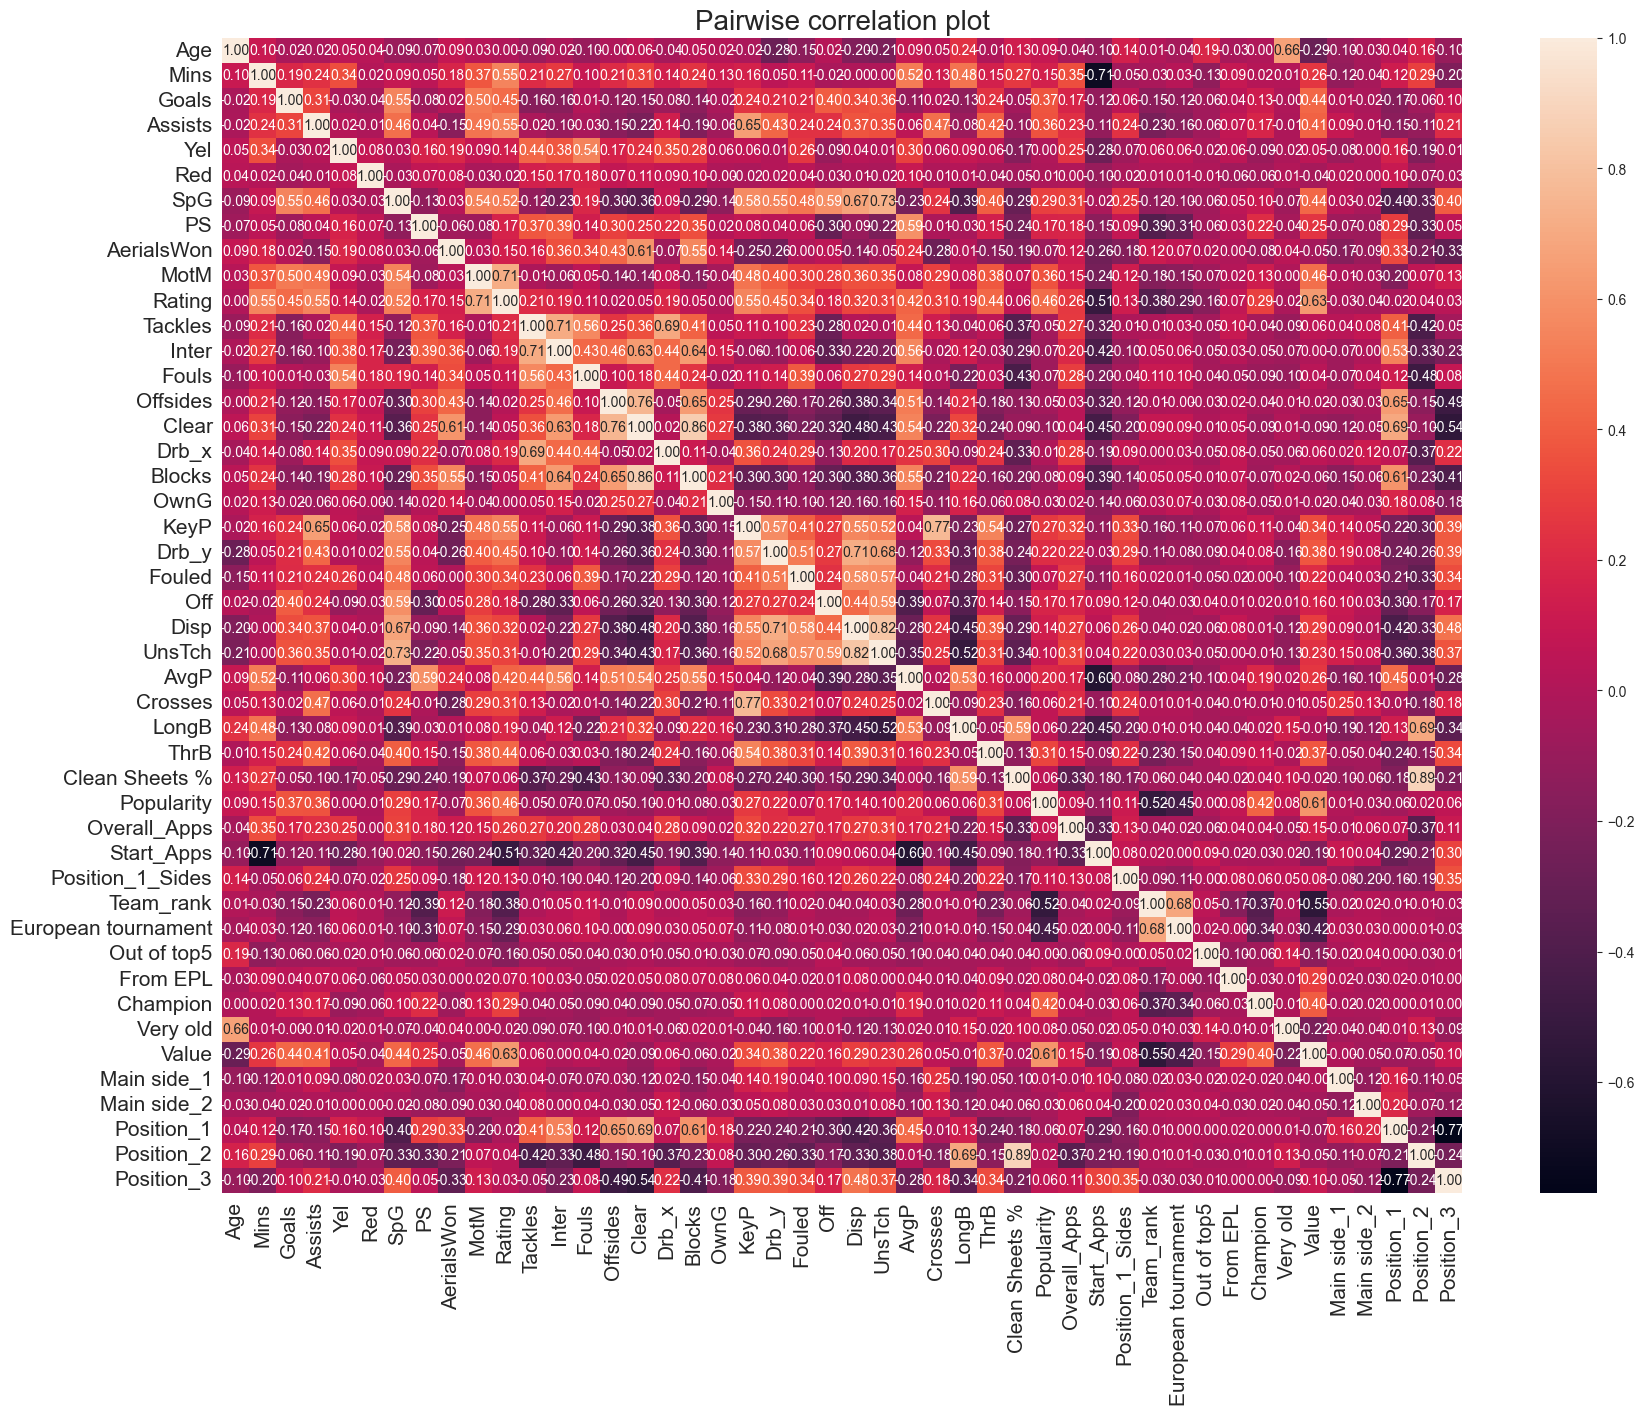

In [91]:
corr_table = df_train.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(corr_table,
            annot=True,
            fmt='.2f',
            ax=ax)

ax.set_title('Pairwise correlation plot', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

**3. LEARNING A MODEL**

This section will be divided into 3 parts. In the first part we will create the DecisionTree model to see how it makes decisions on the data and how well it performs. In the next part we will examine all the basic machine learning models in order to choose the best one. In the final part we will choose one of the algorithms and learn it via GridSearch with a larger hyperparameters grid 

In [92]:
# We use embedded method (ExtraTrees -> feature_importances_) and drop some other variables:
#all_data.drop(['Start_Apps', 'LongB', 'Yel', 'Drb_y', 'Tackles',
#               'Position_1_Sides', 'Clear', 'Assists', 'Position_3',
#               'Position_1', 'Main side_1', 'Position_2', 'Main side_2'], axis=1, inplace=True)

In [93]:
df_train, df_test = divide_df(all_data)

X_train, y_train = df_train.drop('Value', axis=1), df_train['Value']
X_test, y_test = df_test.drop('Value', axis=1), df_test['Value']

feature_names = X_train.columns

#X_train = StandardScaler().fit_transform(X_train)
#X_test = StandardScaler().fit_transform(X_test)

*1. Decision Tree*

In this part we will create a basic decision tree and then visualize it. This model is good at representativeness and interpretability so we must know how to deal with it

In [94]:
# Train a basic model - without any hyperparameter fine-tuning
basic_decision_tree = DecisionTreeRegressor()

In [95]:
basic_decision_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [96]:
def regression_metrics(prediction, reality):
    maximum = max(reality)
    minimum = min(reality)
    
    print(f'RMSE: {root_mean_squared_error(prediction, reality)}')
    print(f'Normalized RMSE: {root_mean_squared_error(prediction, reality)/(maximum-minimum)}')
    print(f'log RMSE: {root_mean_squared_log_error(np.abs(prediction), reality)}')
    print(f'MAPE: {mean_absolute_percentage_error(prediction, reality)}')
    print(f'R2 score: {r2_score(prediction, reality)}')
    
def show_predictions(model):
    answers = pd.DataFrame([test_names.values, y_test.values, pd.Series(model.predict(X_test))]).T
    answers.rename(columns={0: 'Name', 1: 'Test value', 2: 'Predicted value'}, inplace=True)
    
    return answers

def show_importances(features, model):
    feature_importances = pd.DataFrame(model.feature_importances_, index=features, columns=['Importance'])
    feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
    
    return feature_importances

In [97]:
regression_metrics(basic_decision_tree.predict(X_train), y_train)

RMSE: 0.0
Normalized RMSE: 0.0
log RMSE: 0.0
MAPE: 0.0
R2 score: 1.0


In [98]:
regression_metrics(basic_decision_tree.predict(X_test), y_test)

RMSE: 11321487.563264878
Normalized RMSE: 0.07560258806854676
log RMSE: 0.741480314157991
MAPE: 0.7005311999024422
R2 score: 0.6968258223364769


In [99]:
display(show_predictions(basic_decision_tree).sample(5))

Name Test value Predicted value
192      Darwin Núñez   70000000      70000000.0
43        Iván Martín   15000000      25000000.0
182       Reda Khadra    3000000       2000000.0
118  Gianluca Mancini   25000000      10000000.0
291    Evann Guessand    8000000      18000000.0

We see that this model expectedly overfits the data. Let`s somehow adjust our algorithm

In [100]:
vis_decision_tree = DecisionTreeRegressor(max_depth=3)

In [101]:
vis_decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

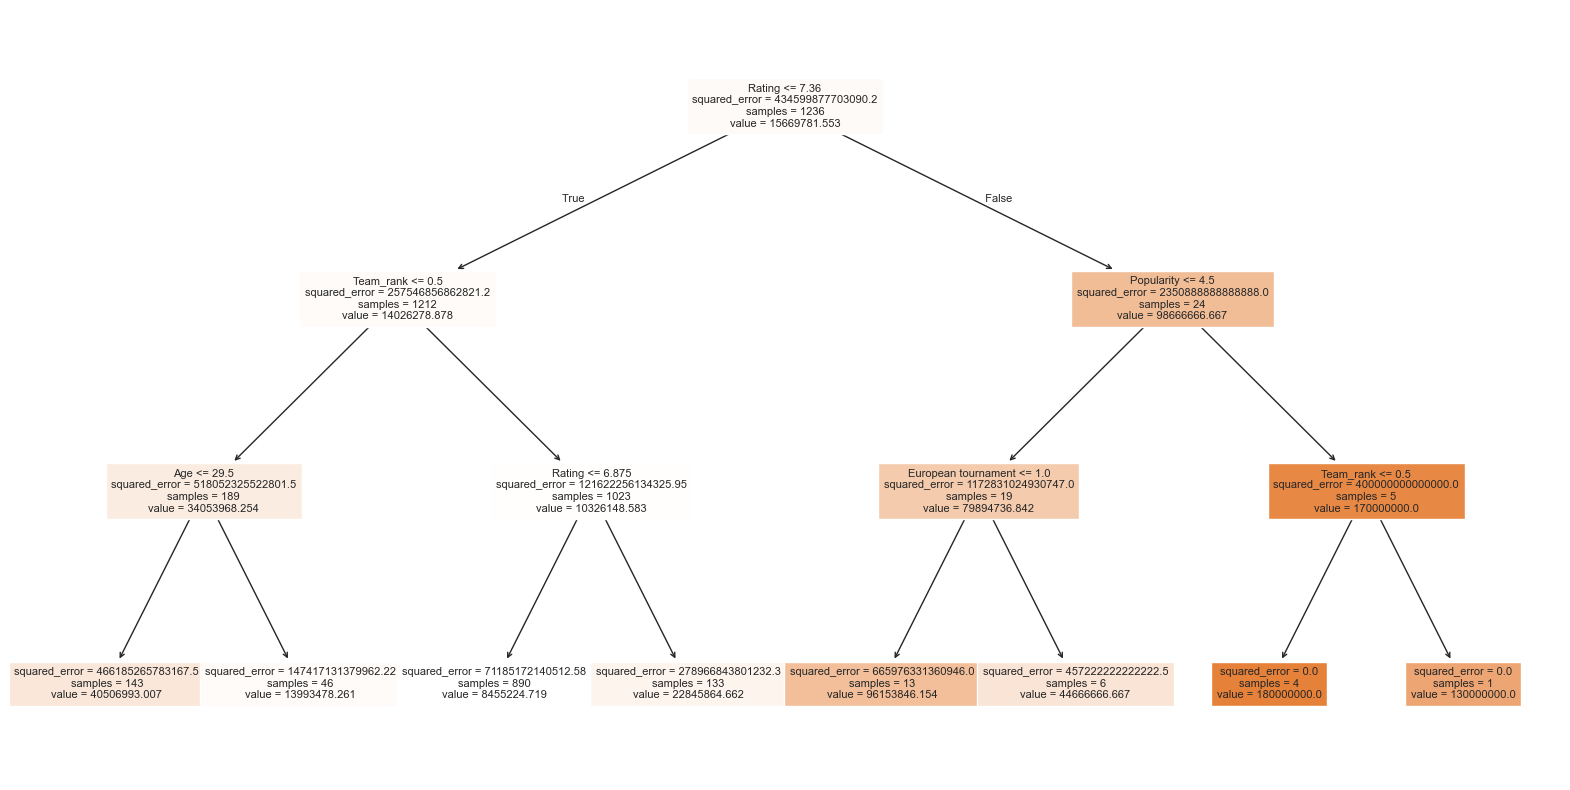

In [102]:
fig, ax = plt.subplots(figsize=(20, 10))

plot_tree(vis_decision_tree, feature_names=feature_names, filled=True, fontsize=8)

plt.show()

In [103]:
display(show_importances(feature_names, vis_decision_tree).head(8))

Importance
Rating                 0.547260
Team_rank              0.260942
Popularity             0.091336
Age                    0.069534
European tournament    0.030929
Main side_1            0.000000
Very old               0.000000
AvgP                   0.000000

The basic decision tree with max_depth = 3 makes its decisions based mainly on the rating, rank of the team in which a footballer plays and his age. So our new feature 'Team_rank' is very important for this ML algorithm. Let`s check the same thing for the first tree

In [104]:
display(show_importances(feature_names, basic_decision_tree))

Importance
Rating                 0.416944
Team_rank              0.185119
Age                    0.095509
Popularity             0.087888
European tournament    0.037592
Mins                   0.032205
From EPL               0.024294
SpG                    0.015048
LongB                  0.009755
PS                     0.008693
Tackles                0.008165
Yel                    0.007831
Position_3             0.007487
Drb_x                  0.006026
Disp                   0.005972
AerialsWon             0.005300
KeyP                   0.005230
Inter                  0.004493
Crosses                0.004267
Fouled                 0.004170
Fouls                  0.004165
AvgP                   0.003472
UnsTch                 0.002797
Off                    0.002517
Blocks                 0.002287
Drb_y                  0.002098
Start_Apps             0.001766
Overall_Apps           0.001616
Position_1_Sides       0.001471
Main side_1            0.001090
MotM                   0.001055
Assists                0.000926
Clear                  0.000851
Offsides               0.000368
ThrB                   0.000363
Goals                  0.000285
Clean Sheets %         0.000278
Red                    0.000249
OwnG                   0.000154
Out of top5            0.000089
Position_1             0.000065
Champion               0.000036
Main side_2            0.000007
Very old               0.000003
Position_2             0.000000

In [105]:
regression_metrics(vis_decision_tree.predict(X_train), y_train)

RMSE: 12244280.750703016
Normalized RMSE: 0.06804268269354274
log RMSE: 1.0408604892026252
MAPE: 0.6752643036853045
R2 score: 0.47336045633658363


In [106]:
regression_metrics(vis_decision_tree.predict(X_test), y_test)

RMSE: 13479015.431982283
Normalized RMSE: 0.09001011974612542
log RMSE: 1.062604527877624
MAPE: 0.7143110864809126
R2 score: 0.06591920476592217


This model has problem with underfitting the data. So let`s use the RandomizedSearch algorithm in order to get the best possible tree. It will be faster than usual GridSearch and may give better performance.

In [107]:
decision_tree_param_grid = {
    'max_depth': [1, 3, 5, 7, 11, 13, 15],
    'min_samples_split': sp_randint(2, 16),
    'min_samples_leaf': sp_randint(2, 16)
}

In [108]:
tune_decision_tree = RandomizedSearchCV(DecisionTreeRegressor(), decision_tree_param_grid, n_iter=300, cv=5, random_state=42)
tune_decision_tree.fit(X_train, y_train)


KeyboardInterrupt



In [ ]:
best_decision_tree = tune_decision_tree.best_estimator_

In [ ]:
best_decision_tree.fit(X_train, y_train)

In [ ]:
show_importances(feature_names, best_decision_tree)

In [ ]:
regression_metrics(best_decision_tree.predict(X_train), y_train)

In [ ]:
regression_metrics(best_decision_tree.predict(X_test), y_test)

In [ ]:
display(show_predictions(best_decision_tree).sample(10))

This model performs better. But we see that it shows poor performance and doesn't use all the features we have. Let's check other ML algorithms and choose the best one

*2. Choosing a model*

In [109]:
all_models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    BaggingRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    ExtraTreesRegressor(),
    
    SVR(),
    NuSVR(),
    
    LinearRegression(),
    SGDRegressor(),
    Ridge(), 
    Lasso(), 
    ElasticNet(), 
    BayesianRidge()
]

In [110]:
cv_splits = KFold(n_splits=5, shuffle=True)

scores_table = pd.DataFrame(columns=['train RMSE', 'test RMSE', 'train RMSE 3std', 'test RMSE 3std'])
predictions_table = pd.DataFrame(y_train, index=y_train.index)

for alg in all_models:
    alg_name = alg.__class__.__name__
    
    cv_results = cross_validate(alg, 
                                X_train, 
                                y_train,
                                cv=cv_splits,
                                scoring='neg_root_mean_squared_error',
                                return_train_score=True)
    
    scores_table.loc[alg_name, 'train RMSE'] = -cv_results['train_score'].mean()
    scores_table.loc[alg_name, 'test RMSE'] = -cv_results['test_score'].mean()
    #scores_table.loc[alg_name, 'train R2'] = cv_results['train_score'].mean()
    #scores_table.loc[alg_name, 'test R2'] = cv_results['test_score'].mean()
    
    scores_table.loc[alg_name, 'train RMSE 3std'] = cv_results['train_score'].std()*3
    scores_table.loc[alg_name, 'test RMSE 3std'] = cv_results['test_score'].std()*3
    #scores_table.loc[alg_name, 'train R2 3std'] = cv_results['train_score'].std()*3
    #scores_table.loc[alg_name, 'test R2 3std'] = cv_results['test_score'].std()*3
    
    alg.fit(X_train, y_train)
    
    predictions_table.loc[:, alg_name] = alg.predict(X_train)
    
scores_table.sort_values(by='test RMSE', ascending=True, inplace=True)

In [111]:
display(scores_table)

train RMSE             test RMSE  \
GradientBoostingRegressor         4735107.09423        8210764.089372   
RandomForestRegressor            3618874.649189         9083452.57901   
ExtraTreesRegressor                        -0.0        9126720.880913   
XGBRegressor                      170380.634008        9360629.235643   
BaggingRegressor                 4467514.233126        9951329.598579   
Lasso                           10261524.898852        10961673.88686   
BayesianRidge                   10323890.577982       11007256.999399   
Ridge                           10250779.173873       11026730.008607   
LinearRegression                10239806.799268       11112849.139385   
AdaBoostRegressor               10428291.821948       11925387.450639   
ElasticNet                      11998489.765604       12229591.310421   
DecisionTreeRegressor                      -0.0       12991133.677813   
NuSVR                           21239321.107204       21152327.531151   
SVR                             22209944.149315       22164181.699315   
SGDRegressor               143267407966943.8125  142275753334983.6875   

                               train RMSE 3std      test RMSE 3std  
GradientBoostingRegressor         661181.39536      3923096.963978  
RandomForestRegressor            290715.041631      3596373.388717  
ExtraTreesRegressor                        0.0      1577922.240079  
XGBRegressor                      39742.631453      2733527.215052  
BaggingRegressor                 349247.969198       3696227.52988  
Lasso                            702107.968922      2720096.320081  
BayesianRidge                    484993.302064      1994550.691297  
Ridge                           1013127.550482      3619905.006686  
LinearRegression                 951696.523045      3729202.412998  
AdaBoostRegressor                 1197692.6144      2637314.517974  
ElasticNet                       991554.550237      5560109.335655  
DecisionTreeRegressor                      0.0      2828529.092542  
NuSVR                           1547770.256694       6006414.77654  
SVR                             1111122.248388      4327458.055655  
SGDRegressor               198747426023586.375  197199666558109.75

We see that the best performance show ensemble and boosting methods like Gradient Boosting or Random Forest, but we also can notice that SVM algorithm obviously has an underfitting problem, so we can try to somehow fine-tune it (using kernels or adjusting the values of hyperparameters). But now we will try to use the RandomForestRegressor and find the best values of hyperparameters via GridSearchCV.

In [144]:
random_forest_grid = {
    'max_depth': range(5, 14, 2),
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(1, 11, 2),
    'max_features': np.arange(0.6, 1.1, 1),
    'n_estimators': [100]
}

In [145]:
tune_random_forest = GridSearchCV(RandomForestRegressor(), random_forest_grid)
tune_random_forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(5, 14, 2),
                         'max_features': array([0.6]),
                         'min_samples_leaf': range(1, 11, 2),
                         'min_samples_split': range(2, 11, 2),
                         'n_estimators': [100]})

In [146]:
best_random_forest = RandomForestRegressor(n_estimators=10000,
                                           max_depth=13,
                                           max_features=0.6,
                                           min_samples_leaf=1,
                                           min_samples_split=2)

In [147]:
best_random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=13, max_features=0.6, n_estimators=10000)

In [148]:
regression_metrics(best_random_forest.predict(X_train), y_train)

RMSE: 3436572.564162453
Normalized RMSE: 0.019097374627187847
log RMSE: 0.37331641732014365
MAPE: 0.20482353751981794
R2 score: 0.9671792278731117


In [149]:
regression_metrics(best_random_forest.predict(X_test), y_test)

RMSE: 8065784.7245330475
Normalized RMSE: 0.0538616676095696
log RMSE: 0.5767975861364459
MAPE: 0.37544002017510786
R2 score: 0.7492333242688423


In [150]:
show_predictions(best_random_forest)

Name Test value  Predicted value
0              Paulo Dybala   20000000  24170435.891398
1          Pervis Estupiñán   30000000  26360770.897416
2                Aimar Oroz   15000000   7281436.617995
3    Maximilian Mittelstädt   17000000  27271120.454897
4              Marc Cardona    1400000   2824532.763198
..                      ...        ...              ...
305           Juanmi Latasa    2800000   5964399.429792
306           Pedro Pereira    1500000   3240300.929838
307    Giorgi Mamardashvili   35000000  23570046.193852
308          Edgar González    3000000   5336465.016668
309         Amir Richardson    6000000   4458330.607924

[310 rows x 3 columns]

In [ ]:
basic_random_forest = RandomForestRegressor()
basic_random_forest.fit(X_train, y_train)

In [ ]:
extra_grid_params = {
    'max_depth': [5, 7, 9, 11, 13, 15, 17, 19, 21],
    'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14]
}

In [ ]:
tune_extra_trees = GridSearchCV(ExtraTreesRegressor(), extra_grid_params, scoring='r2', cv=5)
tune_extra_trees.fit(X_train, y_train)

In [ ]:
best_extra_trees = tune_extra_trees.best_estimator_
best_extra_trees.fit(X_train, y_train)

In [ ]:
best_extra_trees = ExtraTreesRegressor(max_depth=19, min_samples_leaf=6, n_estimators=10000)
best_extra_trees.fit(X_train, y_train)

In [ ]:
regression_metrics(best_extra_trees.predict(X_train), y_train)
print('=' * 25)
regression_metrics(np.expm1(best_extra_trees.predict(X_test)), y_test)

In [ ]:
show_importances(feature_names, best_extra_trees)

In [ ]:
a = show_predictions(best_extra_trees)
display(a.sample(20))

In [112]:
xgboost_grid_params = {
    'eta': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7],
    'max_depth': [1, 2, 3, 5, 7, 9],
    'n_estimators': [10, 30, 50, 75, 100, 150, 300],
    'gamma': [0, 0.01, 0.1, 1, 10, 100]
}

In [113]:
tune_xgboost_regressor = RandomizedSearchCV(XGBRegressor(), xgboost_grid_params, n_iter=30, scoring='neg_mean_squared_error', cv=5)
tune_xgboost_regressor.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=30,
                   param_distributions={'eta': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5,
                                                0.7],
                                        'gamma': [0, 0.01, 0.1, 1, 10, 100],
                                        'max_depth': [1, 2, 3, 5, 7, 9],
                                        'n_estimators': [10, 30, 50, 75, 100,
                                                         150, 300]},
                   scoring='neg_mean_squared_error')

In [114]:
best_xgboost_regressor = tune_xgboost_regressor.best_estimator_
best_xgboost_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=10, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [115]:
regression_metrics(best_xgboost_regressor.predict(X_train), y_train)

RMSE: 3536393.1962315473
Normalized RMSE: 0.019652087781225604
log RMSE: 0.5613692749147746
MAPE: 0.617304969969048
R2 score: 0.9688641428947449


In [116]:
regression_metrics(best_xgboost_regressor.predict(X_test), y_test)

RMSE: 7684373.684753307
Normalized RMSE: 0.051314682368970334
log RMSE: 0.703592650120956
MAPE: 0.8466228210433762
R2 score: 0.8090478181838989


In [118]:
pred = show_predictions(best_xgboost_regressor)

In [119]:
pred[abs(pred['Test value'] - pred['Predicted value']) > 15000000]

Name Test value Predicted value
8            João Félix   30000000      50138452.0
36       Benjamin Sesko   50000000      27040960.0
39         Jacob Murphy   15000000      32193580.0
44        Jack Grealish   60000000      44607932.0
68    Federico Valverde  120000000      85682848.0
91        Evan Ferguson   50000000      23243944.0
103     Nicolas Jackson   35000000      57007732.0
115   Eduardo Camavinga  100000000      76446496.0
121       Mohamed Salah   55000000      36485972.0
136     Conor Gallagher   50000000      68723336.0
140    Robin Le Normand   40000000      20428810.0
168   Jean-Clair Todibo   35000000      16581604.0
181         André Onana   35000000      54296244.0
185      Dusan Vlahovic   65000000      33873132.0
188          Phil Foden  150000000     170105296.0
190     Tim Kleindienst    6000000      31438838.0
195          Pedro Neto   55000000      37606908.0
208      Moisés Caicedo   75000000      43933036.0
230  Georges Mikautadze   15000000      31457286.0
240        Oihan Sancet   35000000      13785486.0
256         Deniz Undav   25000000      41684520.0
287      Victor Osimhen  100000000      64952360.0

In [ ]:
ridge_grid_params = {
    'alpha': [1, 3, 5, 7, 10, 20],
}

In [ ]:
fine_ridge_regressor = GridSearchCV(Ridge(), ridge_grid_params, scoring='neg_mean_squared_error', cv=5)
fine_ridge_regressor.fit(X_train, y_train)

In [ ]:
best_ridge_regressor = fine_ridge_regressor.best_estimator_
best_ridge_regressor.fit(X_train, y_train)

In [ ]:
regression_metrics(best_ridge_regressor.predict(X_train), y_train)
print('=' * 25)
regression_metrics(best_ridge_regressor.predict(X_test), y_test)

In [ ]:
pred2 = show_predictions(best_ridge_regressor)

In [ ]:
pred2[abs(pred2['Test value'] - pred2['Predicted value']) > 15000000]